In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix

<font size=8>**数据加载**</font>

In [11]:
# 加载原始数据
initial_data = np.load('initial_data/initial_data_rolling.npz')
X_reg_ini = initial_data['X_reg_ini']
y_reg_ini = initial_data['y_reg_ini']

# 回归任务数据（标准化后）
processed_data = np.load('processed_data/processed_data_rolling.npz')
X_reg_sca = processed_data['X_reg_scaled']
y_reg_sca = processed_data['y_reg']

# 加载 PCA 降维后的回归数据
pca_data = np.load('features_rolling/pca_features.npz')
X_reg_pca = pca_data['X_pca']
y_reg_pca = pca_data['y_reg']

# 加载 Select 10 Best 回归特征
reg_select_data = np.load('features_rolling/select10best_regression_features.npz')
X_selected_reg = reg_select_data['X_selected_reg']
y_selected_reg = reg_select_data['y_reg']

# 加载 Select 50 Best 回归特征
reg_select_data = np.load('features_rolling/select50best_regression_features.npz')
X_selected_reg_50 = reg_select_data['X_selected_reg_50']
y_selected_reg_50 = reg_select_data['y_reg']

# 加载 Select 10 Best 清洗回归特征
reg_select_data = np.load('features_rolling/select10best_cleaned_regression_features.npz')
X_selected_reg_cleaned = reg_select_data['X_reg_cleaned']
y_selected_reg_cleaned = reg_select_data['y_reg']

<font size=8>**滚动预测训练函数以及评估指标**</font>

In [13]:
def rolling_evaluate_model_regression(model, X, y, n_splits=5, use_gridsearch=False, param_grid=None,
                                      scoring='neg_mean_squared_error', data_name='未命名数据集',n_jobs=-1):
    """
    使用 TimeSeriesSplit 对回归模型进行滚动预测训练与评估

    参数：
        model: 要训练的回归模型 如 RandomForestRegressor
        X, y: 特征矩阵与标签
        n_splits: 滚动折数
        use_gridsearch: 是否进行超参数网格搜索
        param_grid: 若使用网格搜索，提供参数字典
        scoring: 网格搜索评分指标
        data_name: 当前使用的数据来源标记（仅用于打印）
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {'mse': [], 'mae': [], 'r2': []}
    best_model = None
    best_score = float('-inf')  # R² 越高越好

    print(f"\n===== 开始滚动评估：{data_name} {n_splits} 折=====\n")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if use_gridsearch and param_grid is not None:
            search = GridSearchCV(model, param_grid=param_grid, scoring=scoring, cv=3,  n_jobs=n_jobs)
            search.fit(X_train, y_train)
            fitted_model = search.best_estimator_
            model_info = search.best_params_
        else:
            fitted_model = model.fit(X_train, y_train)
            model_info = model.get_params()

        y_pred = fitted_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        metrics['mse'].append(mse)
        metrics['mae'].append(mae)
        metrics['r2'].append(r2)

        if r2 > best_score:
            best_score = r2
            best_model = fitted_model
            best_metrics = {'mse': mse, 'mae': mae, 'r2': r2}
            best_params = model_info

        print(f"[Fold {fold}] MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}

    print(f"\n=== 平均性能指标 {data_name} ===")
    print(f"MSE: {avg_metrics['mse']:.4f}, MAE: {avg_metrics['mae']:.4f}, R2: {avg_metrics['r2']:.4f}")
    print("\n=== 最佳模型参数 ===")
    print(best_params)
    print("对应指标:", best_metrics)

    
    # 使用最佳模型在最后一个折的数据上预测并绘图
    X_test_final = X[test_idx]
    y_test_final = y[test_idx]
    y_pred_final = best_model.predict(X_test_final)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_final, y_pred_final, alpha=0.5)
    plt.plot([y_test_final.min(), y_test_final.max()],
                [y_test_final.min(), y_test_final.max()],
                'r--', lw=2)
    plt.xlabel('Actual Nights')
    plt.ylabel('Predicted Nights')
    plt.title(f'{data_name} - Best Fold: Actual vs Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model, metrics, avg_metrics, best_params


In [14]:
def plot_rolling_metrics(metrics_dict):
    """
    可视化每一折的回归指标(MSE, MAE, R²)
    """
    folds = range(1, len(metrics_dict['mse']) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(folds, metrics_dict['mse'], marker='o')
    plt.title('MSE per Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    
    plt.subplot(1, 3, 2)
    plt.plot(folds, metrics_dict['mae'], marker='o')
    plt.title('MAE per Fold')
    plt.xlabel('Fold')
    plt.ylabel('MAE')
    
    plt.subplot(1, 3, 3)
    plt.plot(folds, metrics_dict['r2'], marker='o')
    plt.title('R² per Fold')
    plt.xlabel('Fold')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

<font size=8>**模型**</font>

<font size=6>**线性模型**</font>

In [15]:
model_lr = LinearRegression()
param_grid_lr = {} 

<font size=6>**L1 正则**</font>

In [6]:
model_lasso = Lasso(max_iter=10000)
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  # 正则强度，越大惩罚越强
}

<font size=6>**L2 正则**</font>

In [7]:
model_ridge = Ridge(max_iter=10000)
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  # 正则强度
}

<font size=6>**支持向量(SVR)**</font>

In [8]:
model_svr = SVR()
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1],
    'kernel': ['linear', 'rbf']
}

<font size=6>**随机森林**</font>

In [9]:
model_rf = RandomForestRegressor(random_state=42, n_jobs=12)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

<font size=8>**模型训练结果**</font>

<font size=6>**线性模型训练结果**</font>

<font size=5>**原始数据**</font>


===== 开始滚动评估：reg_data_ini 5 折=====

[Fold 1] MSE=336.8344, MAE=5.7650, R2=0.1689
[Fold 2] MSE=9770.1011, MAE=10.4300, R2=-28.7898
[Fold 3] MSE=336.3178, MAE=5.4946, R2=0.0355
[Fold 4] MSE=346.0066, MAE=5.2283, R2=0.0926
[Fold 5] MSE=553.5520, MAE=6.1636, R2=0.0664

=== 平均性能指标 reg_data_ini ===
MSE: 2268.5624, MAE: 6.6163, R2: -5.6853

=== 最佳模型参数 ===
{}
对应指标: {'mse': 336.834418790112, 'mae': 5.7650484791583425, 'r2': 0.1689251321898001}


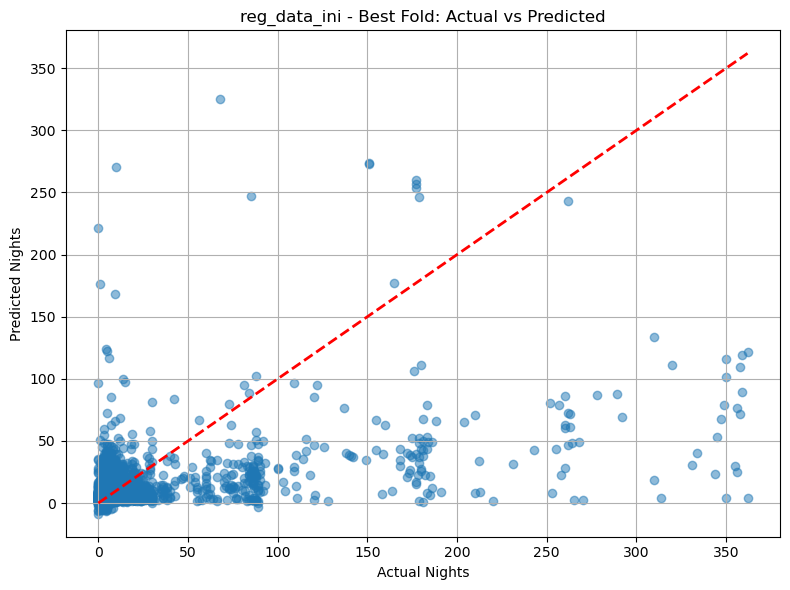

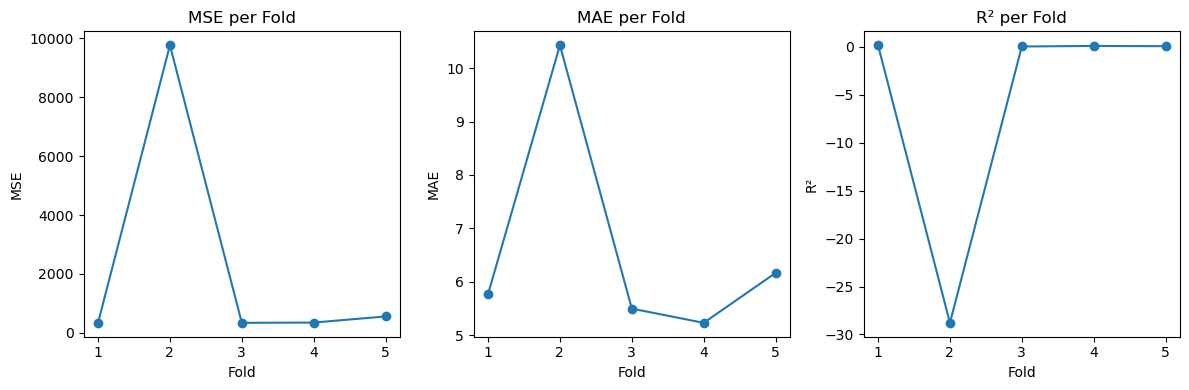

In [16]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lr,
    X_reg_ini,
    y_reg_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lr,
    data_name='reg_data_ini',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**标准化数据**</font>


===== 开始滚动评估：reg_data_sca 5 折=====

[Fold 1] MSE=263.3822, MAE=7.4275, R2=0.3502
[Fold 2] MSE=5990.6823, MAE=11.3312, R2=-17.2660
[Fold 3] MSE=278.0367, MAE=6.4655, R2=0.2026
[Fold 4] MSE=268.0578, MAE=6.3568, R2=0.2971
[Fold 5] MSE=377.1054, MAE=6.7491, R2=0.3640

=== 平均性能指标 reg_data_sca ===
MSE: 1435.4529, MAE: 7.6660, R2: -3.2104

=== 最佳模型参数 ===
{}
对应指标: {'mse': 377.1054321046698, 'mae': 6.7491072047255205, 'r2': 0.3639976342086355}


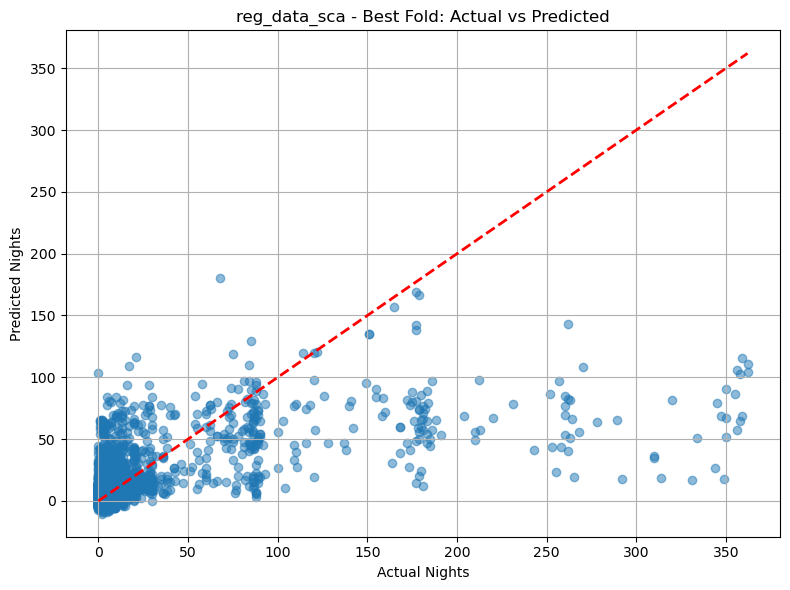

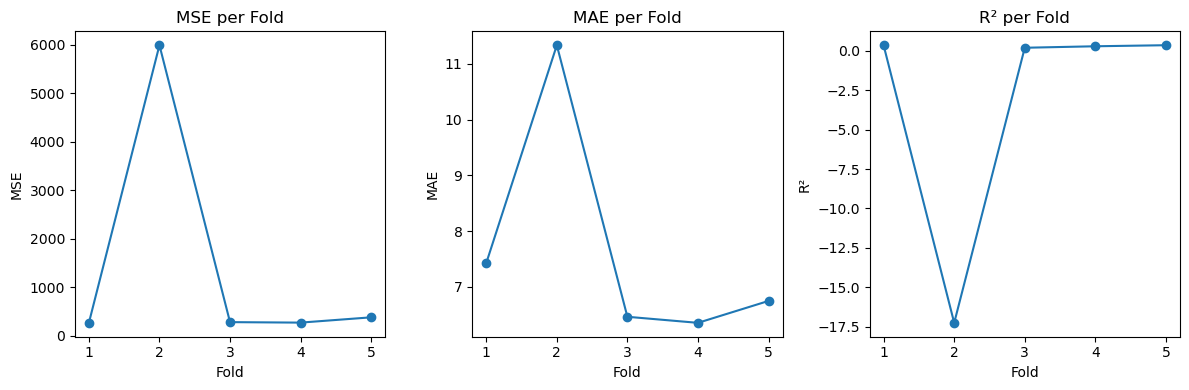

In [17]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lr,
    X_reg_sca,
    y_reg_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lr,
    data_name='reg_data_sca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**PCA数据**</font>


===== 开始滚动评估：reg_data_pca 5 折=====

[Fold 1] MSE=312.1421, MAE=7.1290, R2=0.2298
[Fold 2] MSE=3560.3123, MAE=11.3488, R2=-9.8557
[Fold 3] MSE=307.5704, MAE=6.1773, R2=0.1180
[Fold 4] MSE=341.9268, MAE=6.1012, R2=0.1033
[Fold 5] MSE=524.3376, MAE=7.0610, R2=0.1157

=== 平均性能指标 reg_data_pca ===
MSE: 1009.2578, MAE: 7.5635, R2: -1.8578

=== 最佳模型参数 ===
{}
对应指标: {'mse': 312.14207497859957, 'mae': 7.129005212438937, 'r2': 0.22984879445325734}


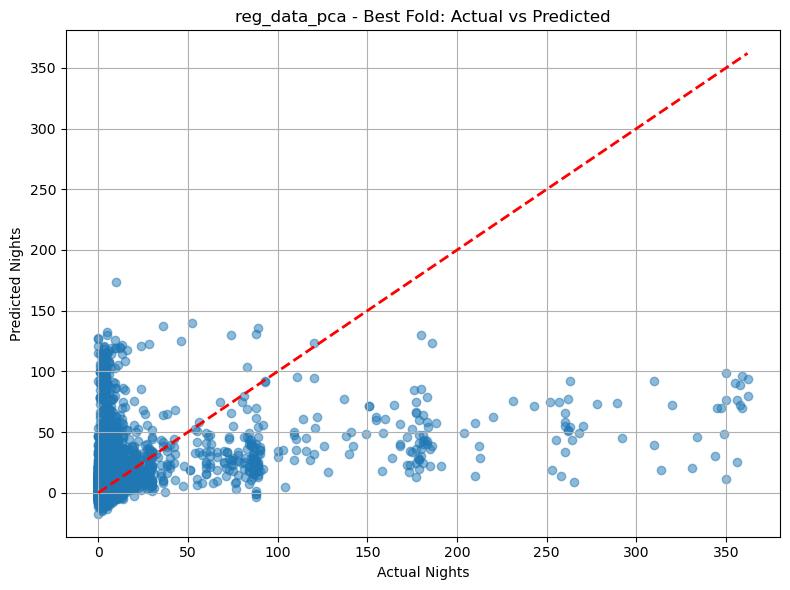

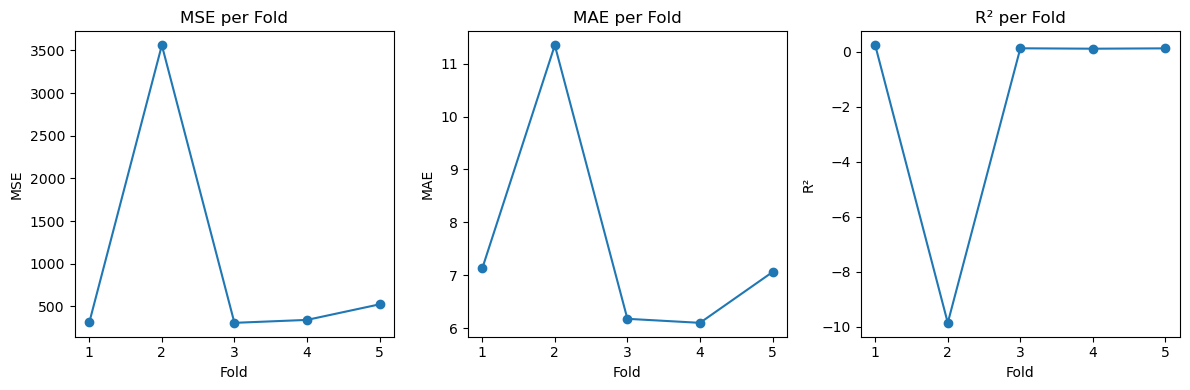

In [18]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lr,
    X_reg_pca,
    y_reg_pca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lr,
    data_name='reg_data_pca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=10最优选择数据**</font>


===== 开始滚动评估：reg_data_Kselect 5 折=====

[Fold 1] MSE=278.5279, MAE=6.3075, R2=0.3128
[Fold 2] MSE=2046.9273, MAE=8.2182, R2=-5.2412
[Fold 3] MSE=288.3372, MAE=5.9866, R2=0.1731
[Fold 4] MSE=272.6182, MAE=5.7060, R2=0.2851
[Fold 5] MSE=394.9776, MAE=6.3758, R2=0.3339

=== 平均性能指标 reg_data_Kselect ===
MSE: 656.2776, MAE: 6.5188, R2: -0.8273

=== 最佳模型参数 ===
{}
对应指标: {'mse': 394.9775961885296, 'mae': 6.375829823225872, 'r2': 0.3338555633938314}


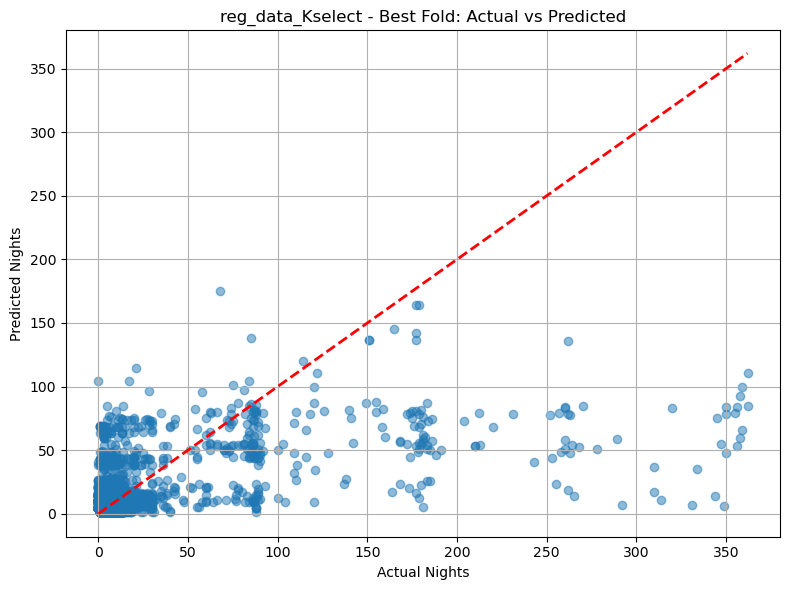

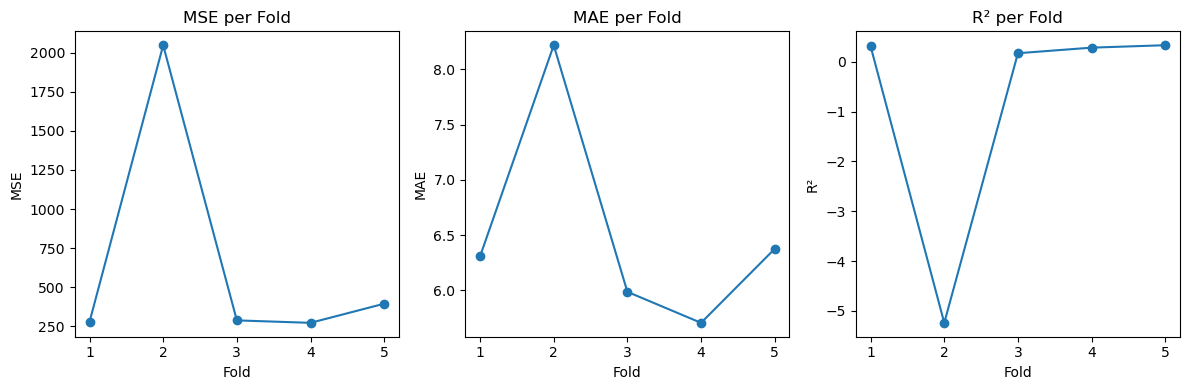

In [54]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lr,
    X_selected_reg,
    y_selected_reg,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lr,
    data_name='reg_data_Kselect',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=50最优选择数据**</font>


===== 开始滚动评估：reg_data_Kselect_50 5 折=====

[Fold 1] MSE=255.0999, MAE=6.6487, R2=0.3706
[Fold 2] MSE=4664.2164, MAE=9.6479, R2=-13.2216
[Fold 3] MSE=278.7787, MAE=5.9347, R2=0.2005
[Fold 4] MSE=269.4189, MAE=6.0050, R2=0.2935
[Fold 5] MSE=382.4730, MAE=6.5599, R2=0.3549

=== 平均性能指标 reg_data_Kselect_50 ===
MSE: 1169.9974, MAE: 6.9592, R2: -2.4004

=== 最佳模型参数 ===
{}
对应指标: {'mse': 255.09989854993748, 'mae': 6.648722783230182, 'r2': 0.3705895162753827}


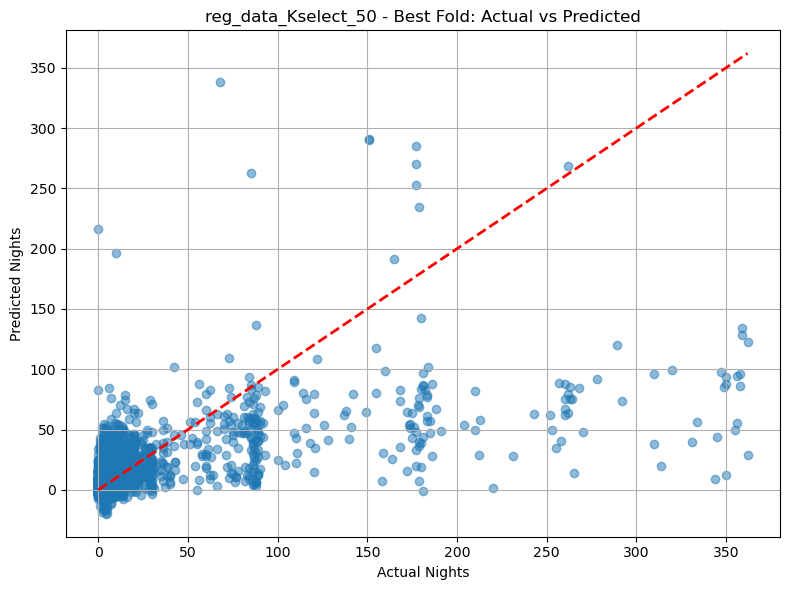

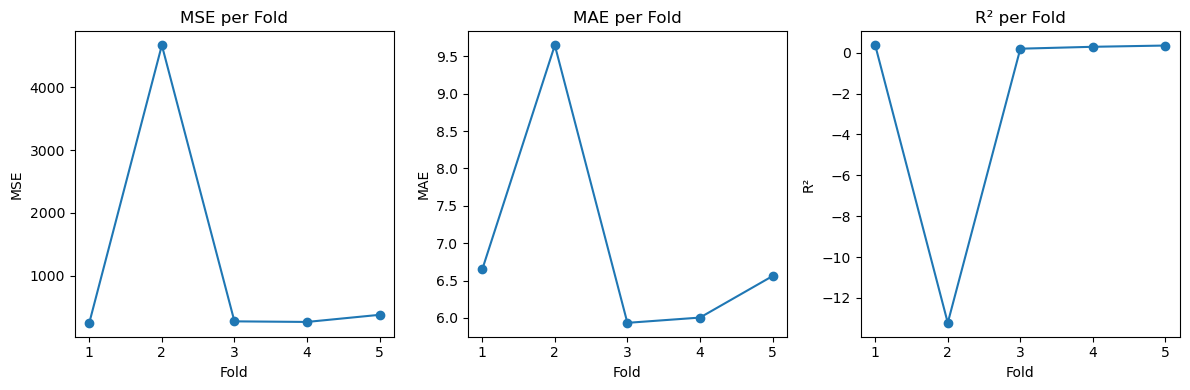

In [12]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lr,
    X_selected_reg_50,
    y_selected_reg_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lr,
    data_name='reg_data_Kselect_50',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始滚动评估：reg_data_Kselect_cleaned 5 折=====

[Fold 1] MSE=18.3113, MAE=2.2221, R2=0.0742
[Fold 2] MSE=22.2196, MAE=2.4794, R2=0.0018
[Fold 3] MSE=18.5999, MAE=2.3345, R2=0.0931
[Fold 4] MSE=17.2894, MAE=2.1478, R2=0.0835
[Fold 5] MSE=13.5112, MAE=2.1708, R2=0.0798

=== 平均性能指标 reg_data_Kselect_cleaned ===
MSE: 17.9863, MAE: 2.2709, R2: 0.0665

=== 最佳模型参数 ===
{}
对应指标: {'mse': 18.599872949497318, 'mae': 2.334512956983599, 'r2': 0.09309458687830618}


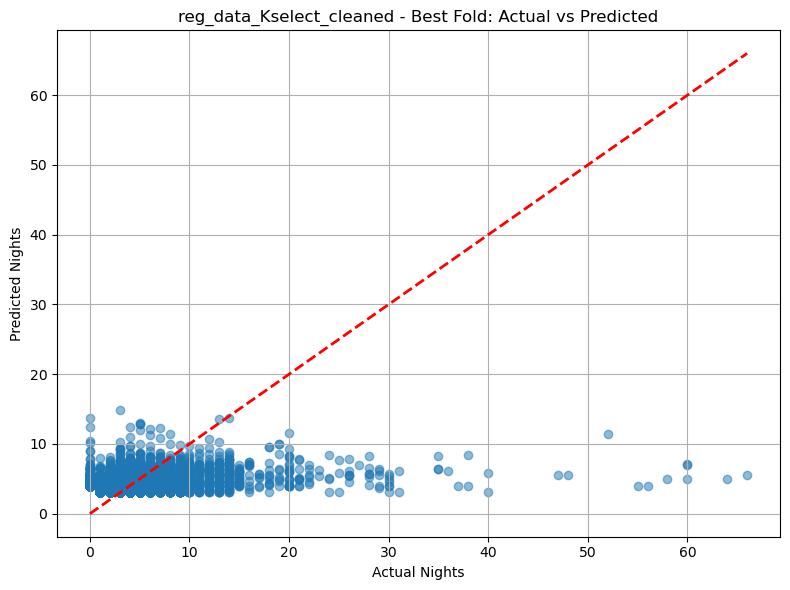

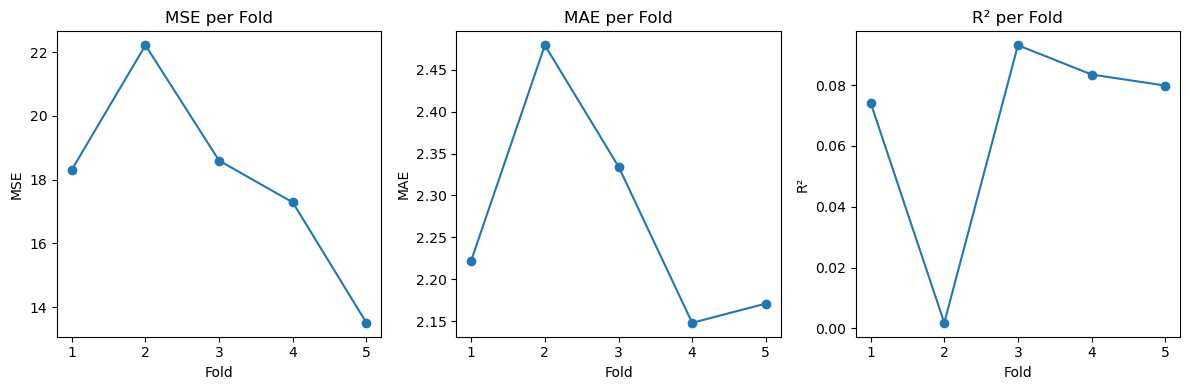

In [20]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lr,
    X_selected_reg_cleaned,
    y_selected_reg_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lr,
    data_name='reg_data_Kselect_cleaned',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=6>**Lasso回归训练结果**</font>

<font size=5>**原始数据**</font>


===== 开始滚动评估：reg_data_ini 5 折=====

[Fold 1] MSE=257.2531, MAE=6.3735, R2=0.3653


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.648e+06, tolerance: 1.007e+03
  model = cd_fast.enet_coordinate_descent(


[Fold 2] MSE=6008.5252, MAE=10.9164, R2=-17.3205


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.900e+06, tolerance: 1.401e+03
  model = cd_fast.enet_coordinate_descent(


[Fold 3] MSE=274.7042, MAE=6.1136, R2=0.2122


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.078e+06, tolerance: 1.820e+03
  model = cd_fast.enet_coordinate_descent(


[Fold 4] MSE=284.7410, MAE=6.1634, R2=0.2533
[Fold 5] MSE=377.8516, MAE=6.5836, R2=0.3627

=== 平均性能指标 reg_data_ini ===
MSE: 1440.6150, MAE: 7.2301, R2: -3.2254

=== 最佳模型参数 ===
{'alpha': 0.1}
对应指标: {'mse': 257.2531129781235, 'mae': 6.373544398766889, 'r2': 0.365276869181005}


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.151e+06, tolerance: 2.278e+03
  model = cd_fast.enet_coordinate_descent(


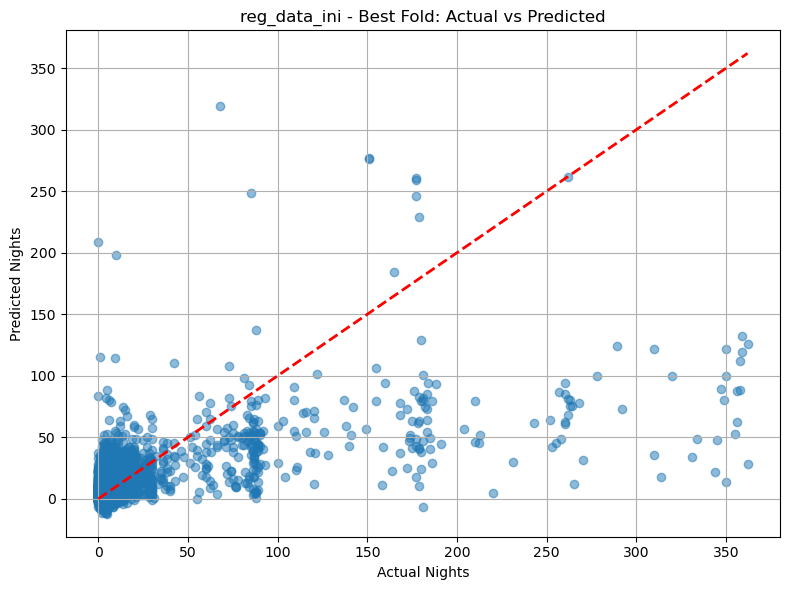

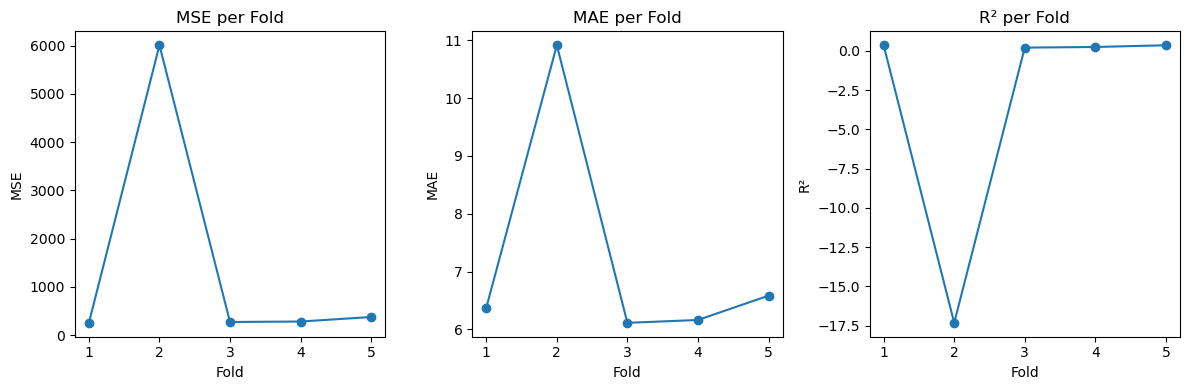

In [10]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lasso,
    X_reg_ini,
    y_reg_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lasso,
    data_name='reg_data_ini',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**标准化数据**</font>


===== 开始滚动评估：reg_data_sca 5 折=====

[Fold 1] MSE=255.2289, MAE=6.7233, R2=0.3703
[Fold 2] MSE=4454.9847, MAE=9.6282, R2=-12.5836
[Fold 3] MSE=348.7290, MAE=5.5576, R2=-0.0001
[Fold 4] MSE=314.9393, MAE=4.8643, R2=0.1741
[Fold 5] MSE=594.3588, MAE=6.4180, R2=-0.0024

=== 平均性能指标 reg_data_sca ===
MSE: 1193.6481, MAE: 6.6383, R2: -2.4083

=== 最佳模型参数 ===
{'alpha': 0.1}
对应指标: {'mse': 255.22887118209349, 'mae': 6.723262092590396, 'r2': 0.3702713008340831}


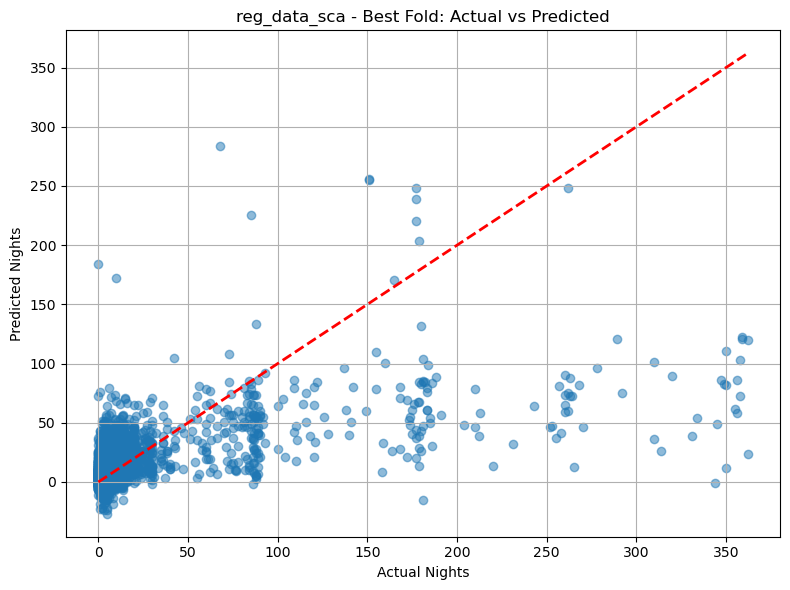

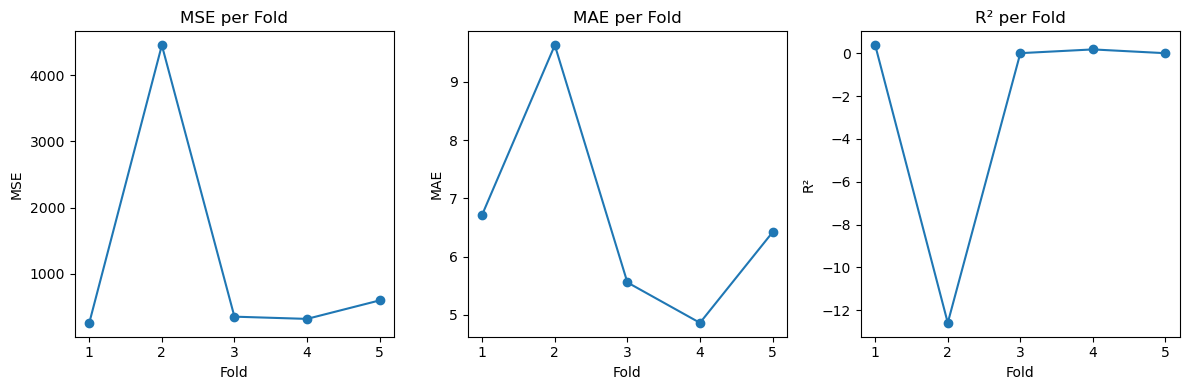

In [11]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lasso,
    X_reg_sca,
    y_reg_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lasso,
    data_name='reg_data_sca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**PCA数据**</font>


===== 开始滚动评估：reg_data_pca 5 折=====

[Fold 1] MSE=312.6796, MAE=6.9356, R2=0.2285
[Fold 2] MSE=3500.8981, MAE=11.2568, R2=-9.6745
[Fold 3] MSE=343.0862, MAE=5.3790, R2=0.0161
[Fold 4] MSE=341.6980, MAE=6.0224, R2=0.1039
[Fold 5] MSE=589.7213, MAE=6.2965, R2=0.0054

=== 平均性能指标 reg_data_pca ===
MSE: 1017.6166, MAE: 7.1781, R2: -1.8641

=== 最佳模型参数 ===
{'alpha': 0.1}
对应指标: {'mse': 312.67960214291963, 'mae': 6.935571767952658, 'r2': 0.22852254840442332}


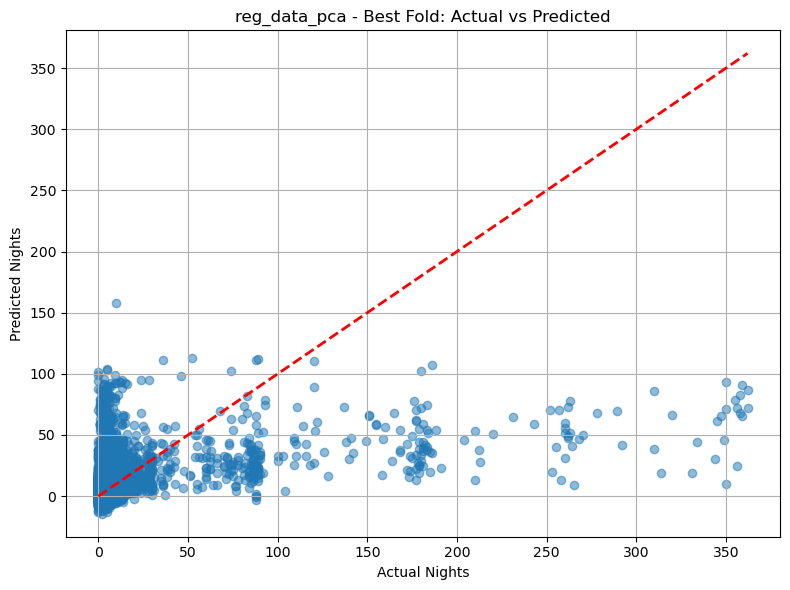

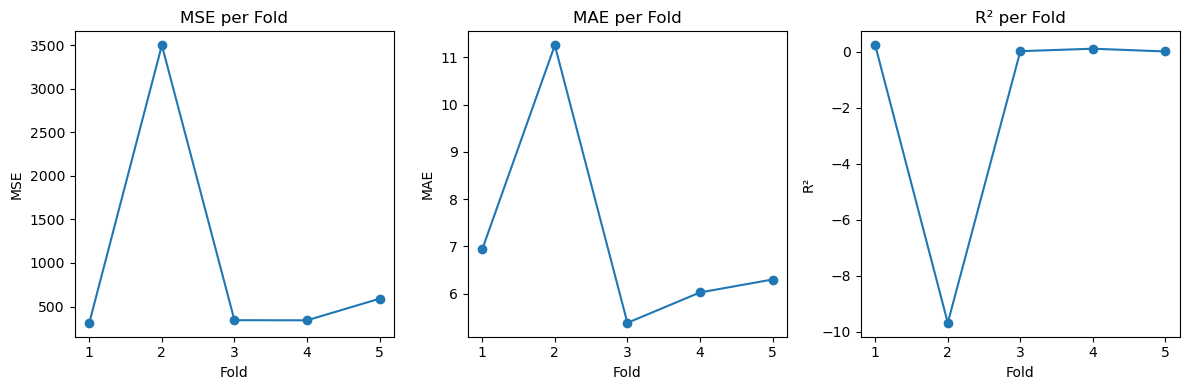

In [12]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lasso,
    X_reg_pca,
    y_reg_pca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lasso,
    data_name='reg_data_pca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=10最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect 5 折=====

[Fold 1] MSE=278.8121, MAE=6.1926, R2=0.3121
[Fold 2] MSE=1873.2836, MAE=7.9888, R2=-4.7118
[Fold 3] MSE=348.7290, MAE=5.5576, R2=-0.0001
[Fold 4] MSE=284.5554, MAE=5.5936, R2=0.2538
[Fold 5] MSE=594.3588, MAE=6.4180, R2=-0.0024

=== 平均性能指标 reg_data_Kselect ===
MSE: 675.9478, MAE: 6.3501, R2: -0.8297

=== 最佳模型参数 ===
{'alpha': 0.1}
对应指标: {'mse': 278.81213011228385, 'mae': 6.1926220309261435, 'r2': 0.3120840945849661}


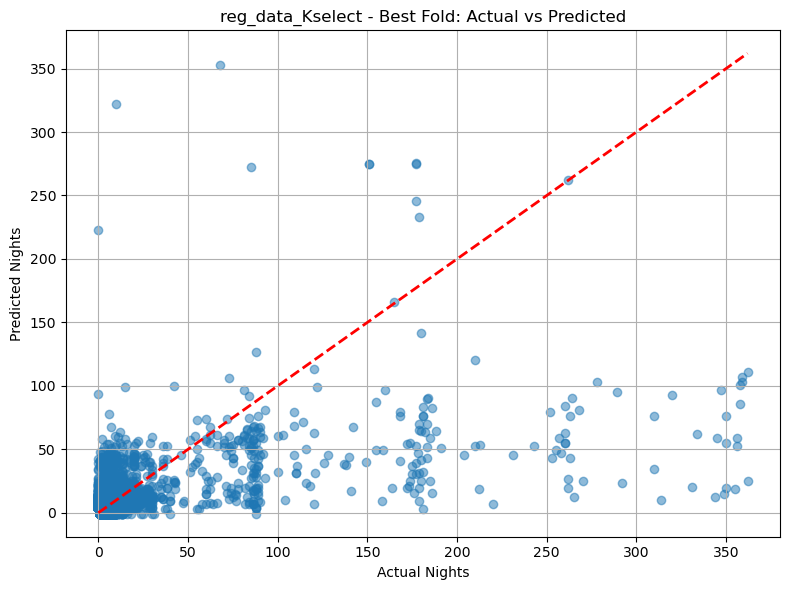

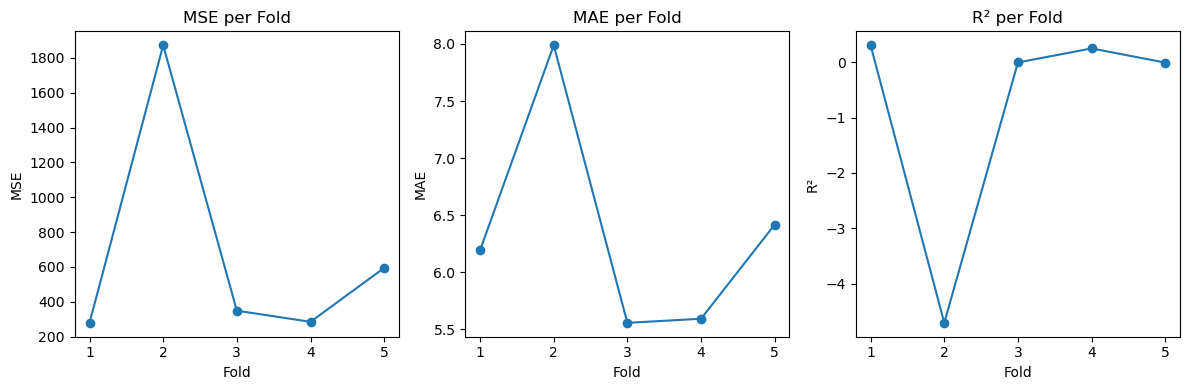

In [13]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lasso,
    X_selected_reg,
    y_selected_reg,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lasso,
    data_name='reg_data_Kselect',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=50最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect_50 5 折=====

[Fold 1] MSE=255.0154, MAE=6.4352, R2=0.3708
[Fold 2] MSE=4084.1204, MAE=9.2168, R2=-11.4528
[Fold 3] MSE=348.7290, MAE=5.5576, R2=-0.0001
[Fold 4] MSE=280.7685, MAE=5.8259, R2=0.2637
[Fold 5] MSE=594.3588, MAE=6.4180, R2=-0.0024

=== 平均性能指标 reg_data_Kselect_50 ===
MSE: 1112.5984, MAE: 6.6907, R2: -2.1642

=== 最佳模型参数 ===
{'alpha': 0.1}
对应指标: {'mse': 255.01536762934325, 'mae': 6.435187052566648, 'r2': 0.3707980802455111}


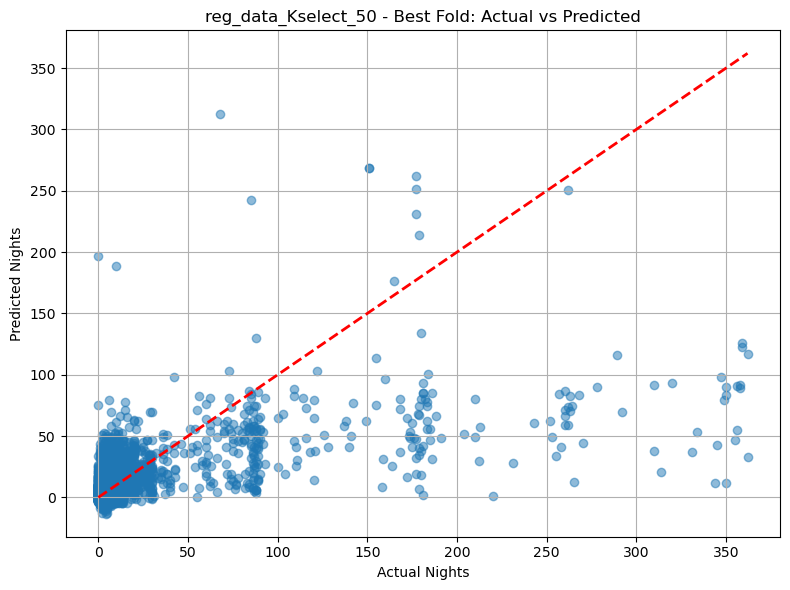

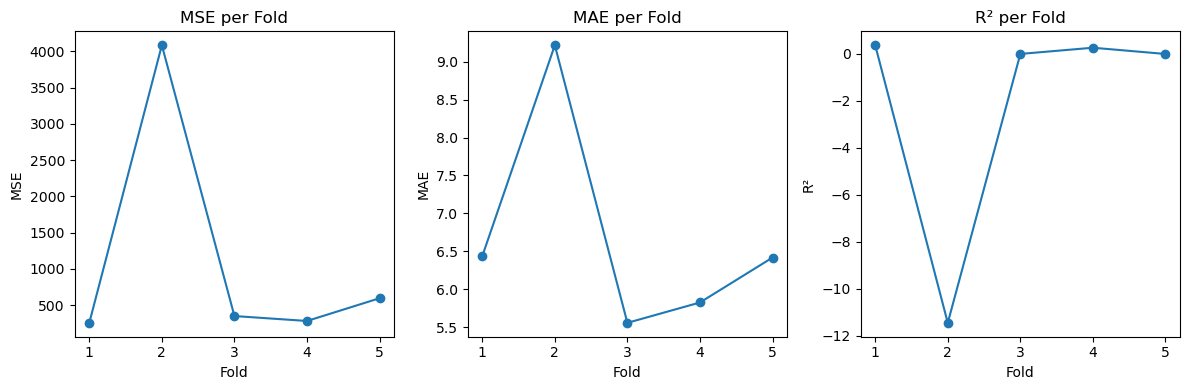

In [13]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lasso,
    X_selected_reg_50,
    y_selected_reg_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lasso,
    data_name='reg_data_Kselect_50',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始滚动评估：reg_data_Kselect_cleaned 5 折=====

[Fold 1] MSE=18.3168, MAE=2.2185, R2=0.0739
[Fold 2] MSE=22.0965, MAE=2.4660, R2=0.0073
[Fold 3] MSE=18.6227, MAE=2.3356, R2=0.0920
[Fold 4] MSE=17.3055, MAE=2.1490, R2=0.0826
[Fold 5] MSE=13.5125, MAE=2.1702, R2=0.0797

=== 平均性能指标 reg_data_Kselect_cleaned ===
MSE: 17.9708, MAE: 2.2679, R2: 0.0671

=== 最佳模型参数 ===
{'alpha': 0.01}
对应指标: {'mse': 18.622695363858195, 'mae': 2.335619106423858, 'r2': 0.09198179588341149}


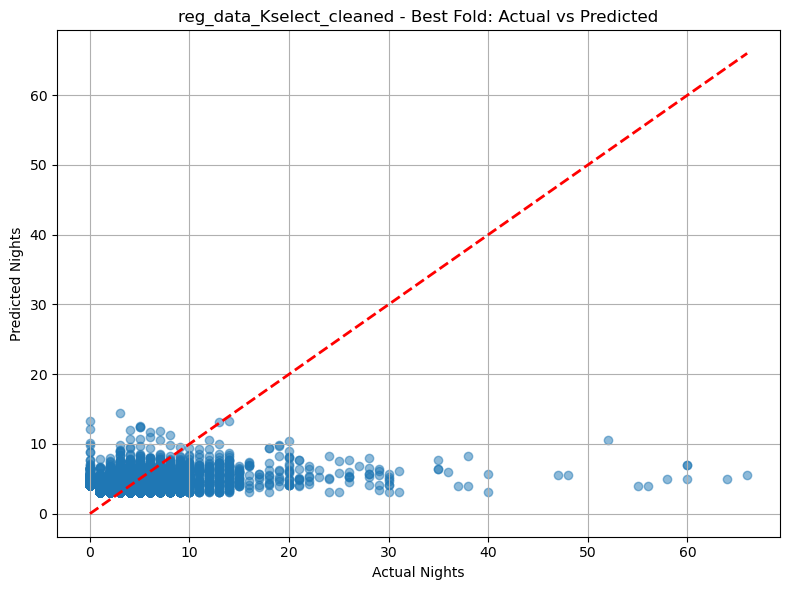

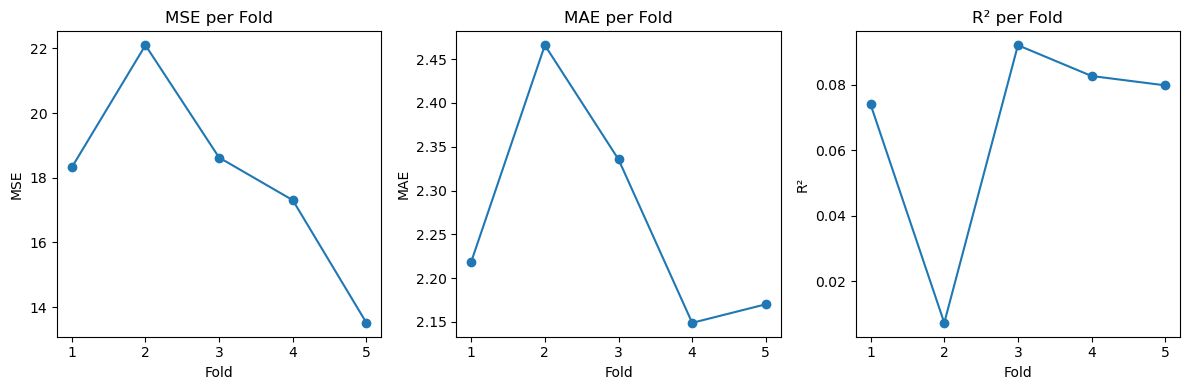

In [21]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_lasso,
    X_selected_reg_cleaned,
    y_selected_reg_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_lasso,
    data_name='reg_data_Kselect_cleaned',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=6>**岭回归训练结果**</font>

<font size=5> **原始数据** </font>


===== 开始滚动评估：reg_data_ini 5 折=====



d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.12509e-14): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[Fold 1] MSE=260.3425, MAE=7.2925, R2=0.3577


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.39888e-15): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[Fold 2] MSE=5985.8452, MAE=11.1883, R2=-17.2513


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.57212e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[Fold 3] MSE=277.2545, MAE=6.4498, R2=0.2049


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.55017e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[Fold 4] MSE=274.2829, MAE=6.3397, R2=0.2807
[Fold 5] MSE=377.1823, MAE=6.7483, R2=0.3639

=== 平均性能指标 reg_data_ini ===
MSE: 1434.9815, MAE: 7.6037, R2: -3.2088

=== 最佳模型参数 ===
{'alpha': 1.0}
对应指标: {'mse': 377.18226210643945, 'mae': 6.748316735696789, 'r2': 0.36386805754723206}


d:\conda\envs\ml\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.53416e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


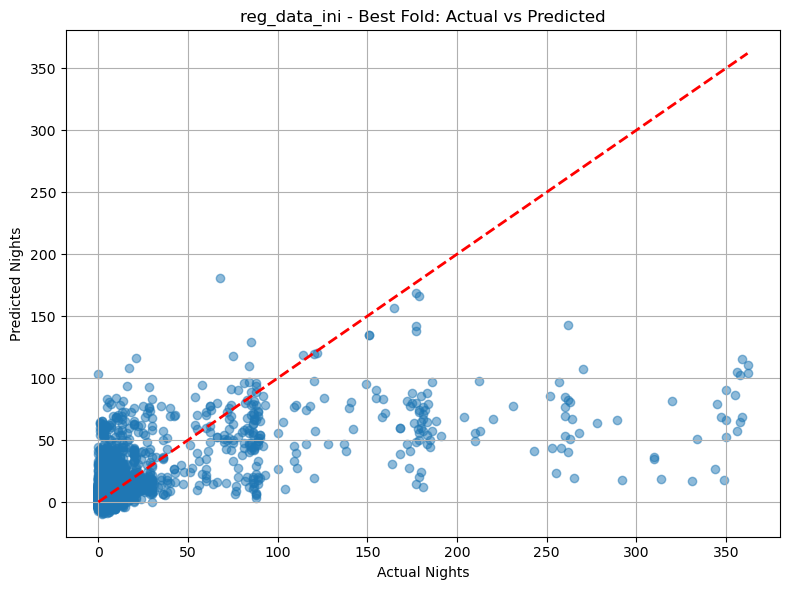

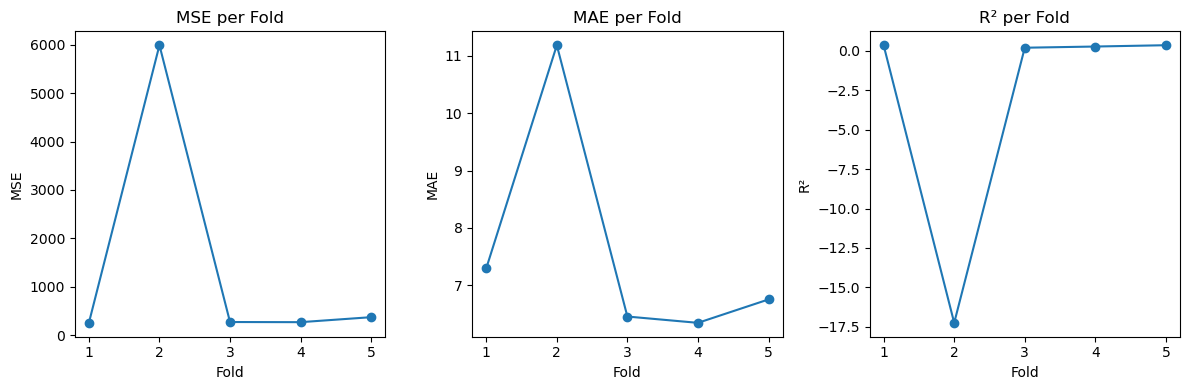

In [12]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_ridge,
    X_reg_ini,
    y_reg_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_ridge,
    data_name='reg_data_ini',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **标准化数据** </font>


===== 开始滚动评估：reg_data_sca 5 折=====

[Fold 1] MSE=262.3633, MAE=7.4057, R2=0.3527
[Fold 2] MSE=5900.5127, MAE=11.2737, R2=-16.9911
[Fold 3] MSE=277.9904, MAE=6.4628, R2=0.2028
[Fold 4] MSE=268.0924, MAE=6.3565, R2=0.2970
[Fold 5] MSE=377.1059, MAE=6.7486, R2=0.3640

=== 平均性能指标 reg_data_sca ===
MSE: 1417.2129, MAE: 7.6495, R2: -3.1549

=== 最佳模型参数 ===
{'alpha': 10.0}
对应指标: {'mse': 377.1058690384959, 'mae': 6.748578920286628, 'r2': 0.3639968973034535}


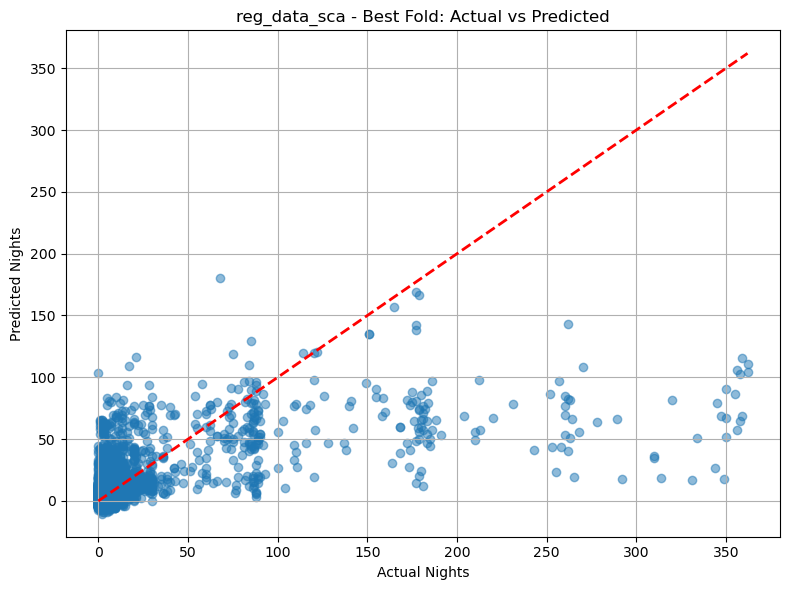

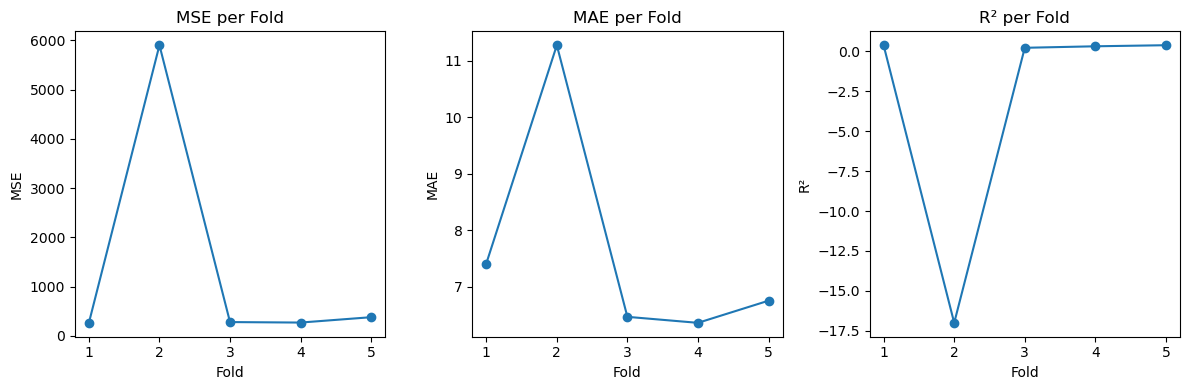

In [13]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_ridge,
    X_reg_sca,
    y_reg_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_ridge,
    data_name='reg_data_sca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **PCA数据** </font>


===== 开始滚动评估：reg_data_pca 5 折=====

[Fold 1] MSE=312.1705, MAE=7.1230, R2=0.2298
[Fold 2] MSE=3546.0854, MAE=11.3339, R2=-9.8123
[Fold 3] MSE=307.5685, MAE=6.1770, R2=0.1180
[Fold 4] MSE=341.9265, MAE=6.1010, R2=0.1033
[Fold 5] MSE=524.3387, MAE=7.0609, R2=0.1157

=== 平均性能指标 reg_data_pca ===
MSE: 1006.4179, MAE: 7.5592, R2: -1.8491

=== 最佳模型参数 ===
{'alpha': 10.0}
对应指标: {'mse': 312.1705189259914, 'mae': 7.122957751317945, 'r2': 0.2297786144226548}


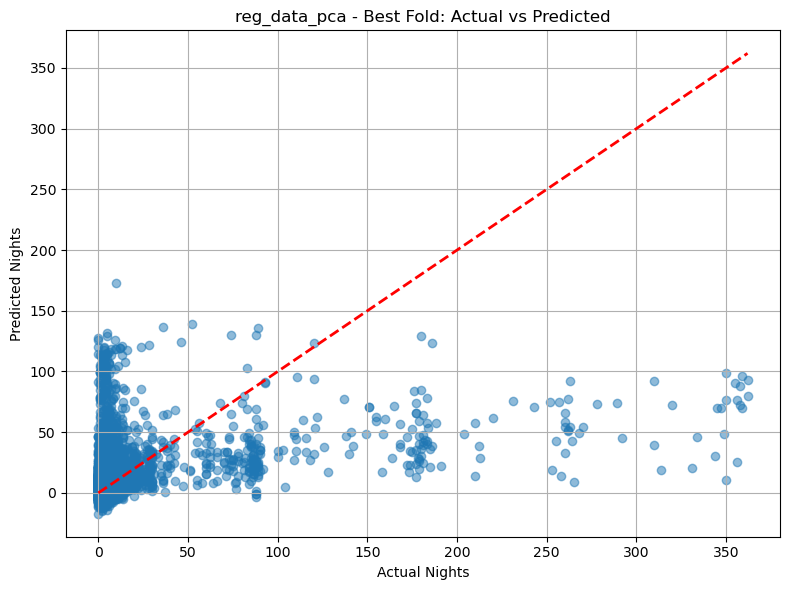

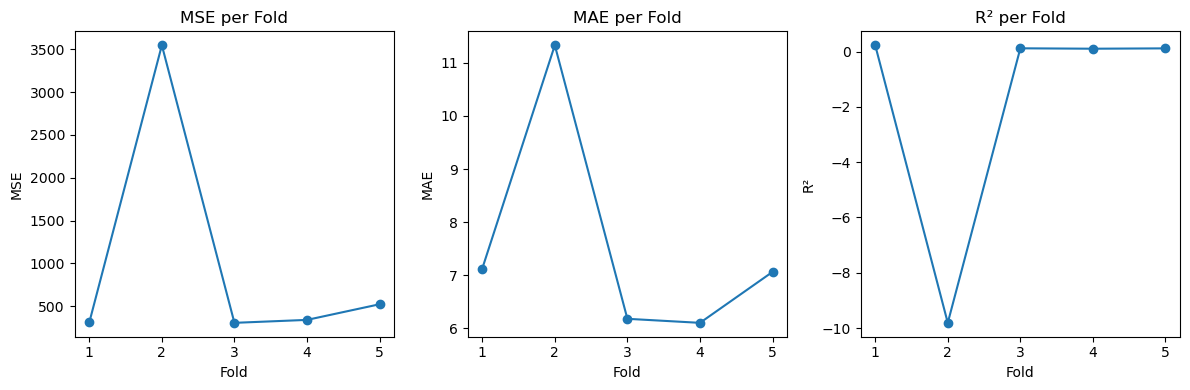

In [14]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_ridge,
    X_reg_pca,
    y_reg_pca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_ridge,
    data_name='reg_data_pca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=10最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect 5 折=====

[Fold 1] MSE=278.6263, MAE=6.3046, R2=0.3125
[Fold 2] MSE=2031.7844, MAE=8.2071, R2=-5.1951
[Fold 3] MSE=288.3358, MAE=5.9861, R2=0.1731
[Fold 4] MSE=272.6580, MAE=5.7056, R2=0.2850
[Fold 5] MSE=394.9882, MAE=6.3756, R2=0.3338

=== 平均性能指标 reg_data_Kselect ===
MSE: 653.2786, MAE: 6.5158, R2: -0.8181

=== 最佳模型参数 ===
{'alpha': 10.0}
对应指标: {'mse': 394.9882411009944, 'mae': 6.375583393986314, 'r2': 0.3338376103522285}


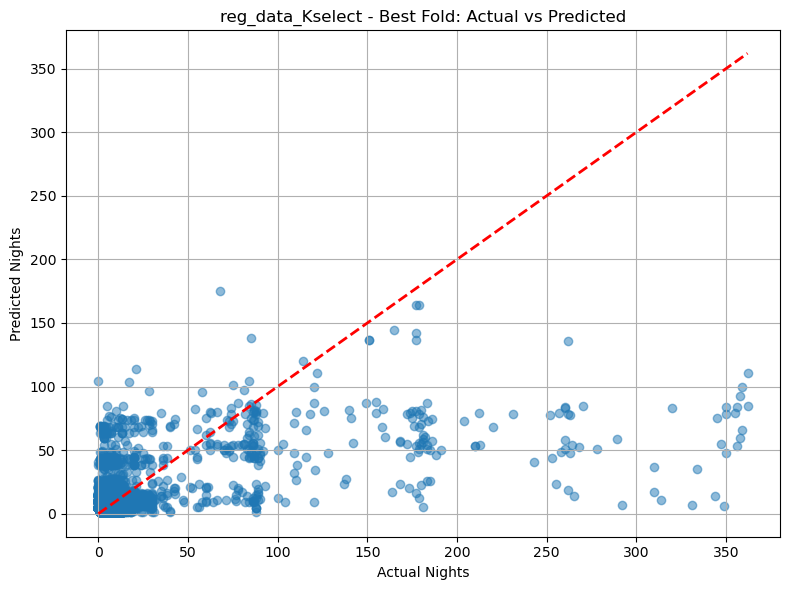

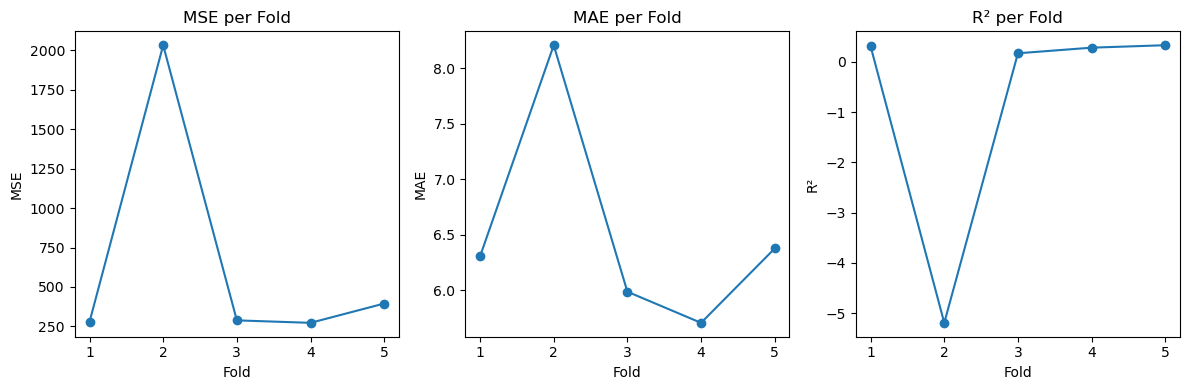

In [15]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_ridge,
    X_selected_reg,
    y_selected_reg,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_ridge,
    data_name='reg_data_Kselect',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=50最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect_50 5 折=====

[Fold 1] MSE=255.2087, MAE=6.6430, R2=0.3703
[Fold 2] MSE=4620.5263, MAE=9.6299, R2=-13.0883
[Fold 3] MSE=278.7732, MAE=5.9341, R2=0.2005
[Fold 4] MSE=269.4585, MAE=6.0046, R2=0.2934
[Fold 5] MSE=382.4843, MAE=6.5596, R2=0.3549

=== 平均性能指标 reg_data_Kselect_50 ===
MSE: 1161.2902, MAE: 6.9542, R2: -2.3738

=== 最佳模型参数 ===
{'alpha': 10.0}
对应指标: {'mse': 255.2087265384551, 'mae': 6.642963155237616, 'r2': 0.3703210039110697}


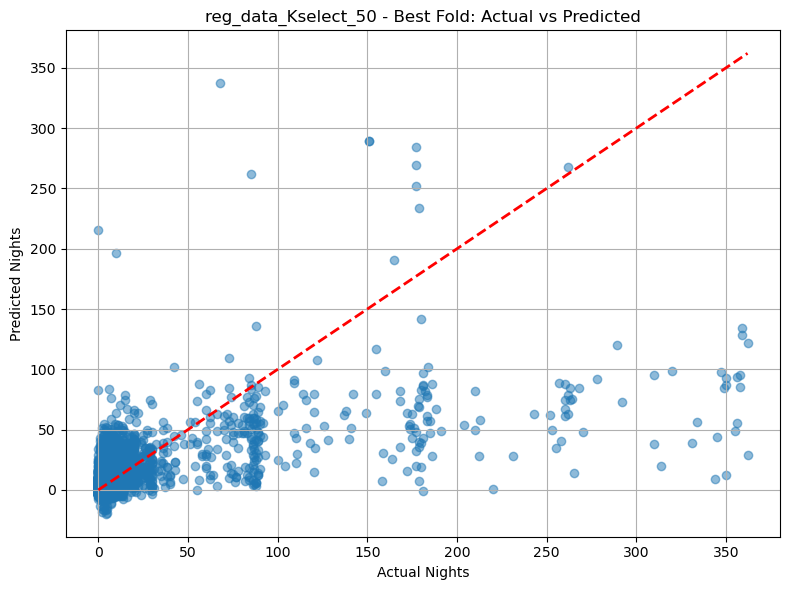

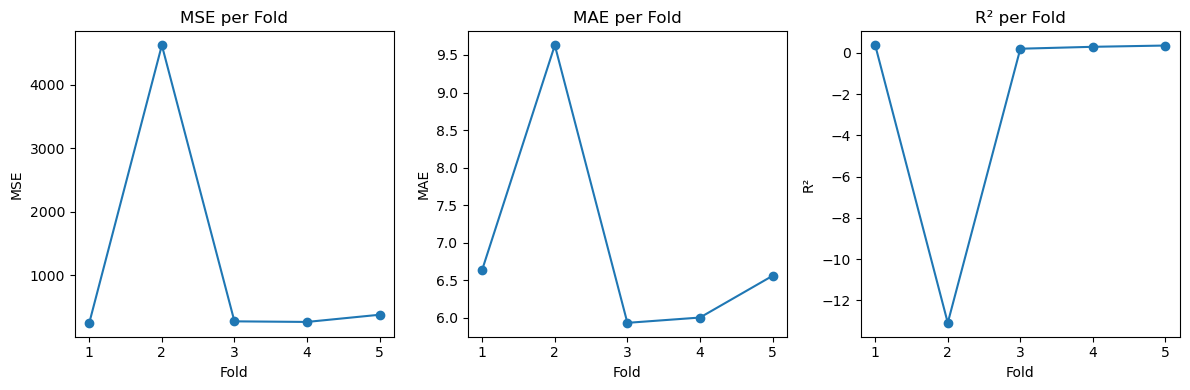

In [14]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_ridge,
    X_selected_reg_50,
    y_selected_reg_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_ridge,
    data_name='reg_data_Kselect_50',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始滚动评估：reg_data_Kselect_cleaned 5 折=====

[Fold 1] MSE=18.3104, MAE=2.2219, R2=0.0742
[Fold 2] MSE=22.1839, MAE=2.4768, R2=0.0034
[Fold 3] MSE=18.6018, MAE=2.3348, R2=0.0930
[Fold 4] MSE=17.2910, MAE=2.1480, R2=0.0834
[Fold 5] MSE=13.5112, MAE=2.1709, R2=0.0798

=== 平均性能指标 reg_data_Kselect_cleaned ===
MSE: 17.9797, MAE: 2.2705, R2: 0.0668

=== 最佳模型参数 ===
{'alpha': 10.0}
对应指标: {'mse': 18.601754198336536, 'mae': 2.3347590464439962, 'r2': 0.09300285965197785}


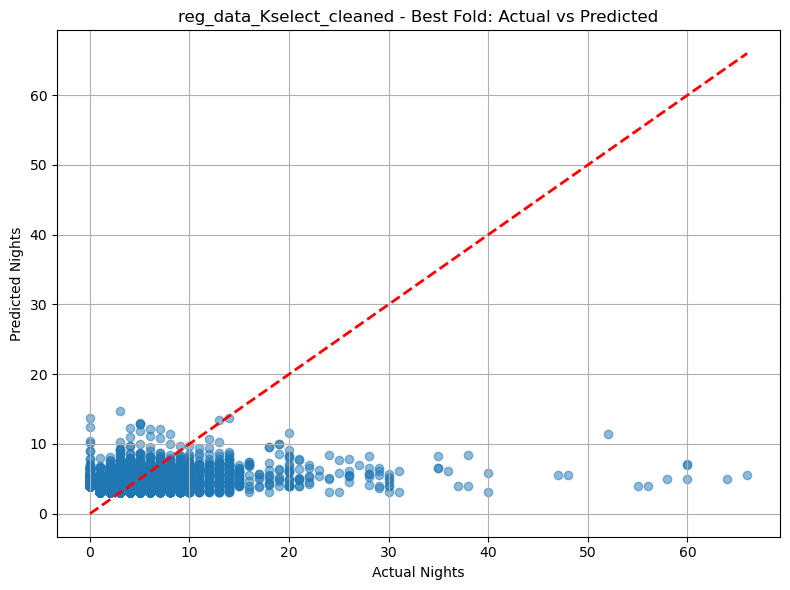

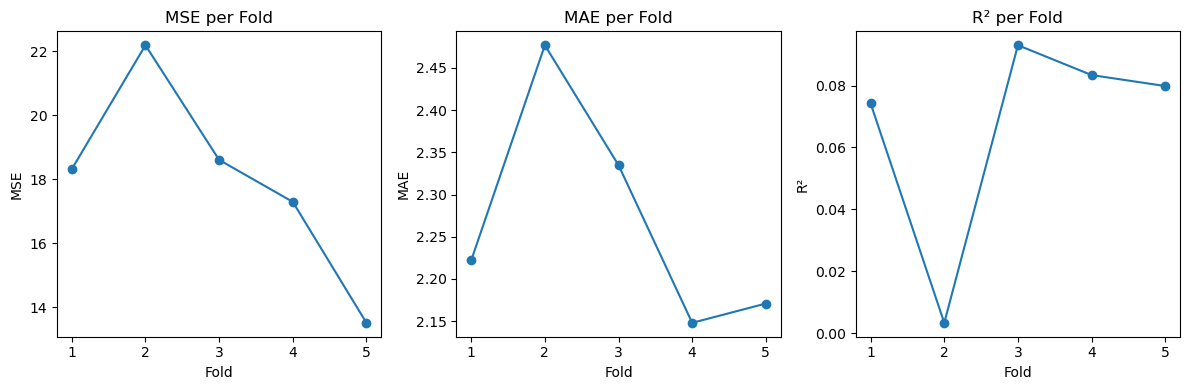

In [22]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_ridge,
    X_selected_reg_cleaned,
    y_selected_reg_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_ridge,
    data_name='reg_data_Kselect_cleaned',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=6>**随机森林训练结果**</font>

<font size=5> **原始数据** </font>

In [ ]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_rf,
    X_reg_ini,
    y_reg_ini,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='reg_data_ini',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **标准化数据** </font>


===== 开始滚动评估：reg_data_sca 5 折=====

[Fold 1] MSE=211.4701, MAE=4.2081, R2=0.4782
[Fold 2] MSE=304.0424, MAE=5.5388, R2=0.0730
[Fold 3] MSE=184.8663, MAE=3.8326, R2=0.4698
[Fold 4] MSE=183.9467, MAE=3.6730, R2=0.5176
[Fold 5] MSE=211.6675, MAE=3.8089, R2=0.6430

=== 平均性能指标 reg_data_sca ===
MSE: 219.1986, MAE: 4.2123, R2: 0.4363

=== 最佳模型参数 ===
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
对应指标: {'mse': 211.66752159838455, 'mae': 3.8089345490881836, 'r2': 0.6430148360726828}


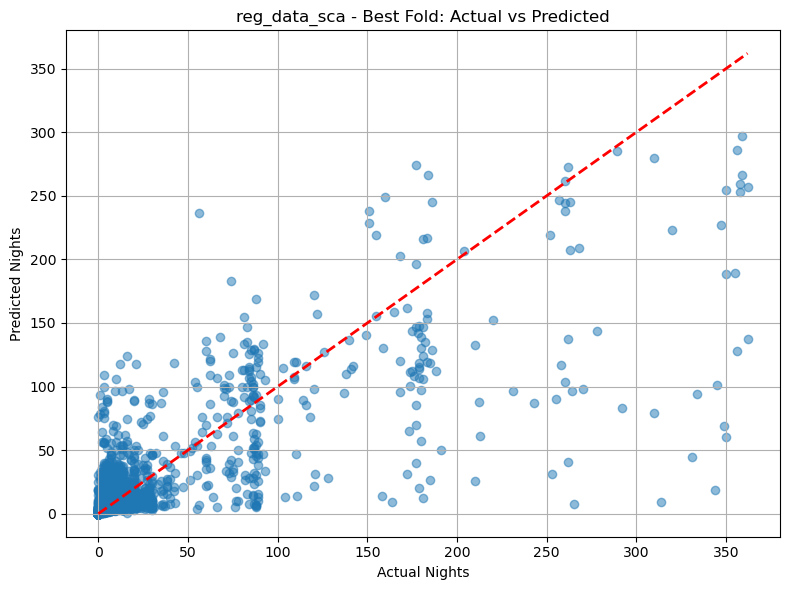

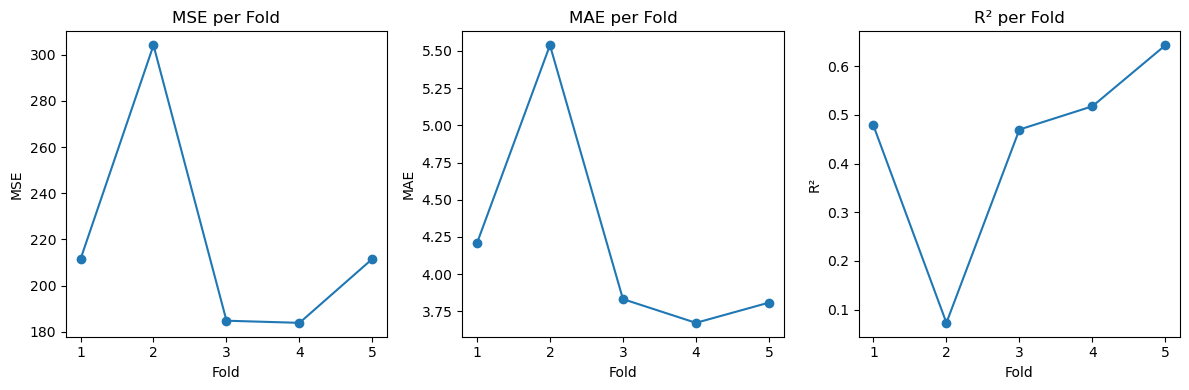

In [16]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_rf,
    X_reg_sca,
    y_reg_sca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='reg_data_sca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **PCA数据** </font>


===== 开始滚动评估：reg_data_pca 5 折=====

[Fold 1] MSE=284.2872, MAE=5.3487, R2=0.2986
[Fold 2] MSE=383.5303, MAE=6.5348, R2=-0.1694
[Fold 3] MSE=257.9379, MAE=4.7256, R2=0.2603
[Fold 4] MSE=264.6351, MAE=4.8651, R2=0.3060
[Fold 5] MSE=353.9304, MAE=5.4302, R2=0.4031

=== 平均性能指标 reg_data_pca ===
MSE: 308.8642, MAE: 5.3809, R2: 0.2197

=== 最佳模型参数 ===
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
对应指标: {'mse': 353.9304162752935, 'mae': 5.430228162211675, 'r2': 0.4030831621271105}


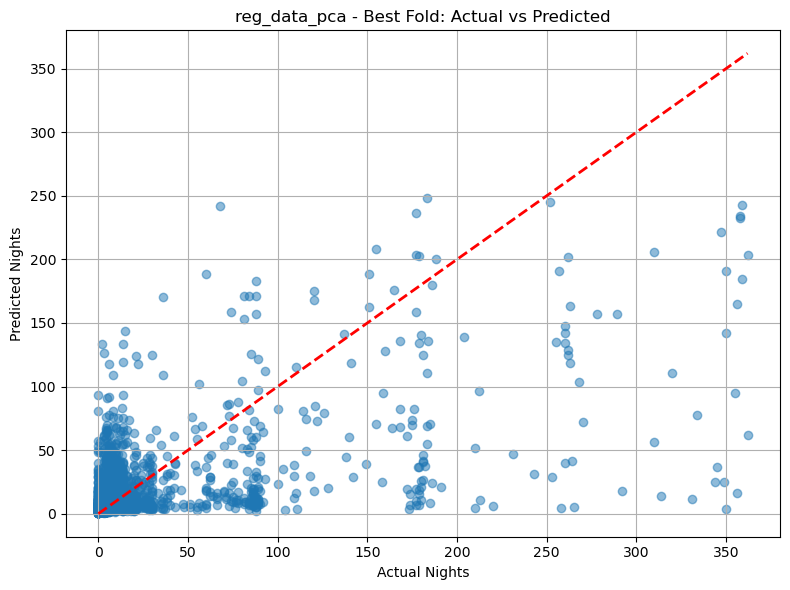

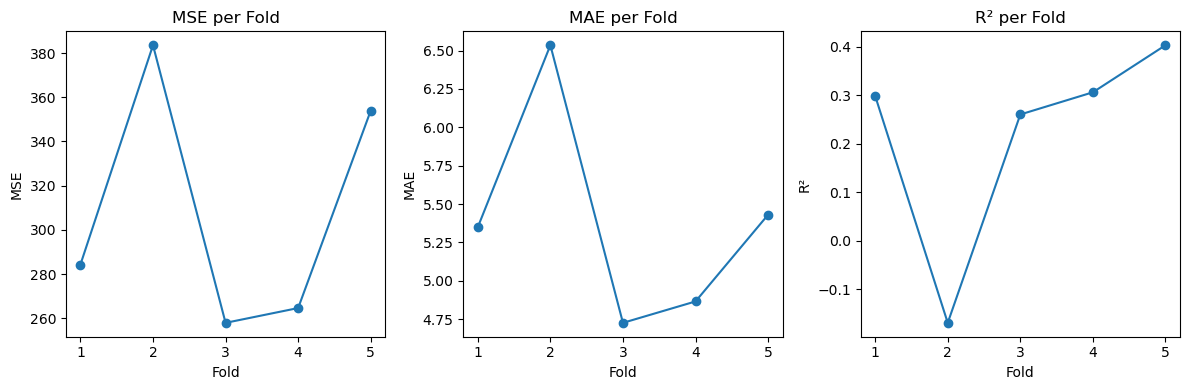

In [18]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_rf,
    X_reg_pca,
    y_reg_pca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='reg_data_pca',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=10最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect 5 折=====

[Fold 1] MSE=196.5421, MAE=4.1510, R2=0.5151
[Fold 2] MSE=244.8156, MAE=4.8132, R2=0.2535
[Fold 3] MSE=232.4115, MAE=4.2022, R2=0.3335
[Fold 4] MSE=203.0266, MAE=3.8641, R2=0.4676
[Fold 5] MSE=255.8492, MAE=4.3461, R2=0.5685

=== 平均性能指标 reg_data_Kselect ===
MSE: 226.5290, MAE: 4.2753, R2: 0.4276

=== 最佳模型参数 ===
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
对应指标: {'mse': 255.84923667341693, 'mae': 4.34613620032537, 'r2': 0.5685007269663436}


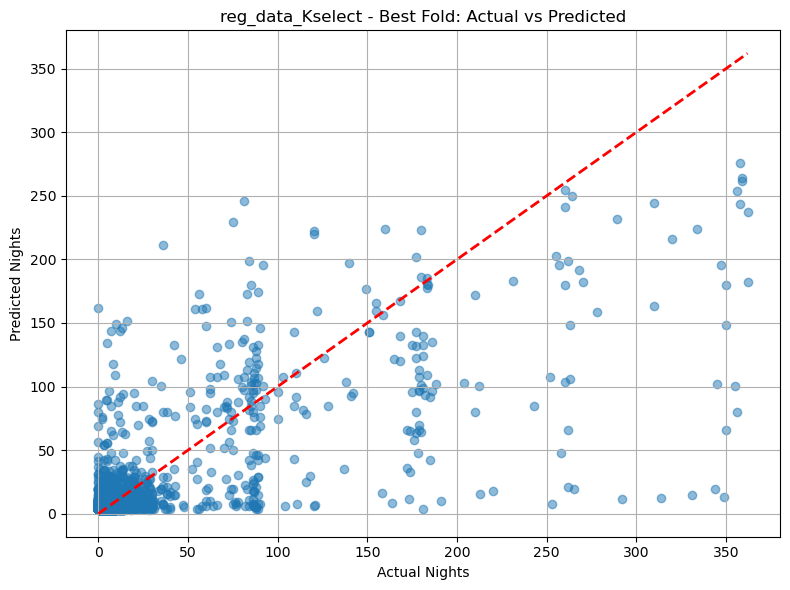

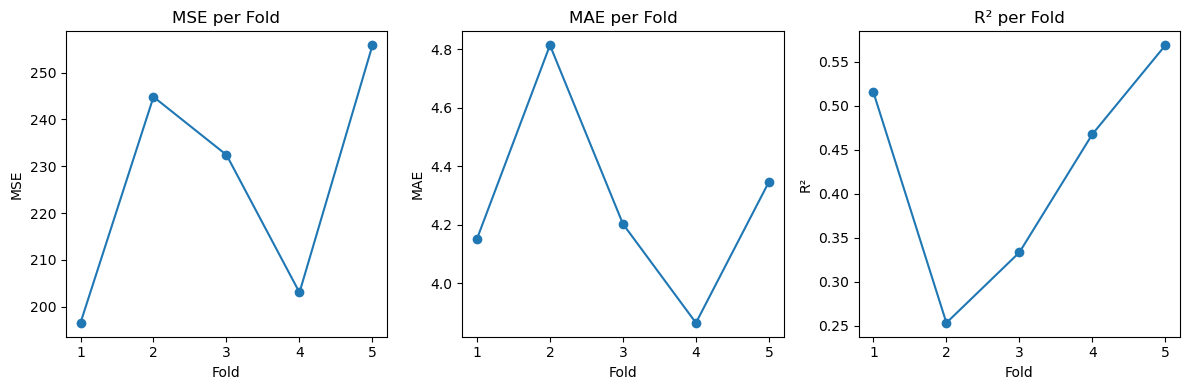

In [17]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_rf,
    X_selected_reg,
    y_selected_reg,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='reg_data_Kselect',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=50最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect_50 5 折=====

[Fold 1] MSE=197.2213, MAE=4.2446, R2=0.5134
[Fold 2] MSE=296.4568, MAE=5.3218, R2=0.0961
[Fold 3] MSE=193.1003, MAE=3.7999, R2=0.4462
[Fold 4] MSE=183.1465, MAE=3.6573, R2=0.5197
[Fold 5] MSE=234.9864, MAE=4.1050, R2=0.6037

=== 平均性能指标 reg_data_Kselect_50 ===
MSE: 220.9823, MAE: 4.2257, R2: 0.4358

=== 最佳模型参数 ===
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
对应指标: {'mse': 234.98638010633204, 'mae': 4.104996446361579, 'r2': 0.6036867121158468}


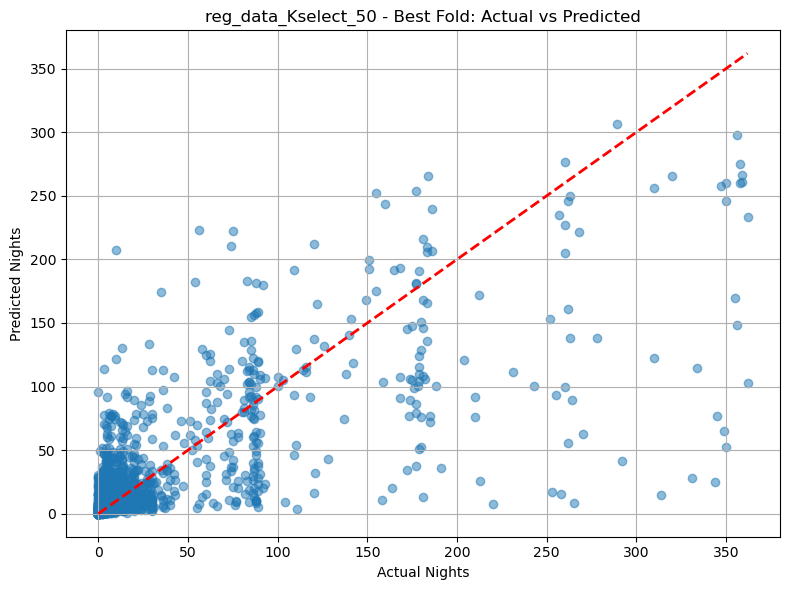

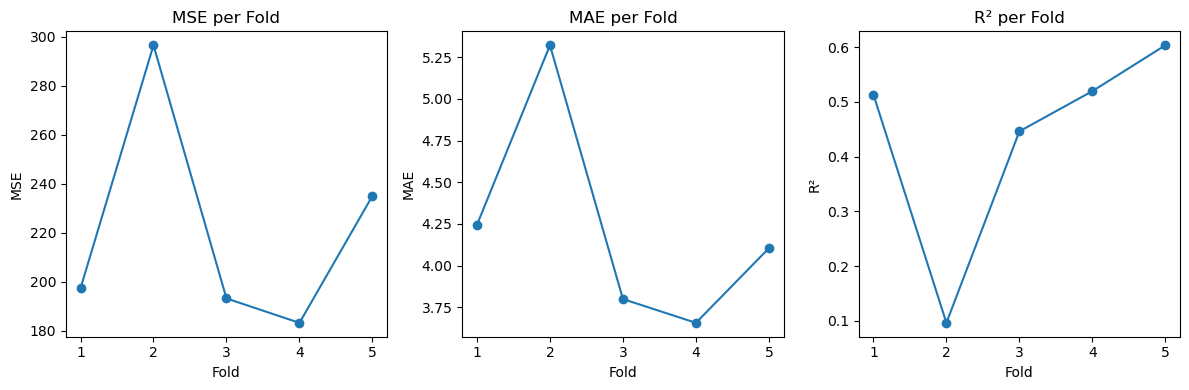

In [15]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_rf,
    X_selected_reg_50,
    y_selected_reg_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='reg_data_Kselect_50',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始滚动评估：reg_data_Kselect_cleaned 5 折=====

[Fold 1] MSE=17.7608, MAE=2.1529, R2=0.1020
[Fold 2] MSE=21.3350, MAE=2.4645, R2=0.0415
[Fold 3] MSE=17.6212, MAE=2.2466, R2=0.1408
[Fold 4] MSE=16.5217, MAE=2.0615, R2=0.1242
[Fold 5] MSE=12.9729, MAE=2.0930, R2=0.1165

=== 平均性能指标 reg_data_Kselect_cleaned ===
MSE: 17.2423, MAE: 2.2037, R2: 0.1050

=== 最佳模型参数 ===
{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
对应指标: {'mse': 17.621191296397278, 'mae': 2.2466144288238223, 'r2': 0.14081382083916516}


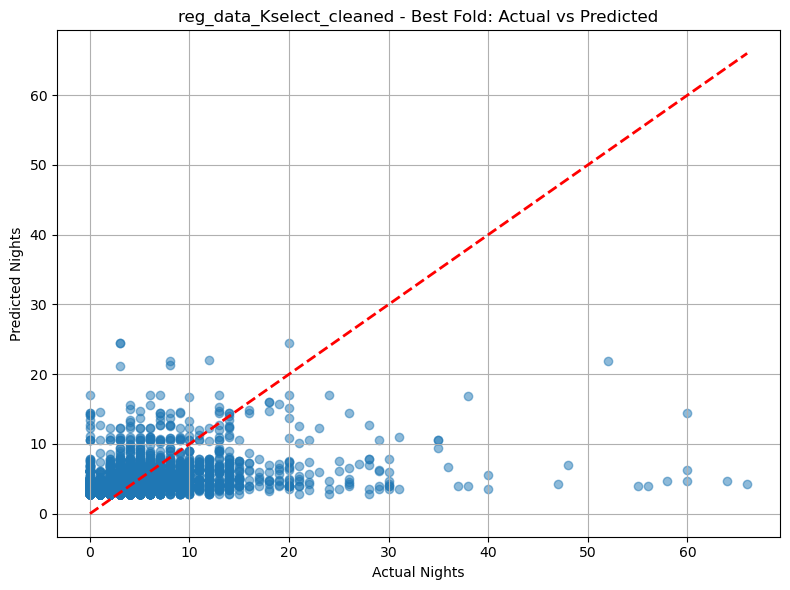

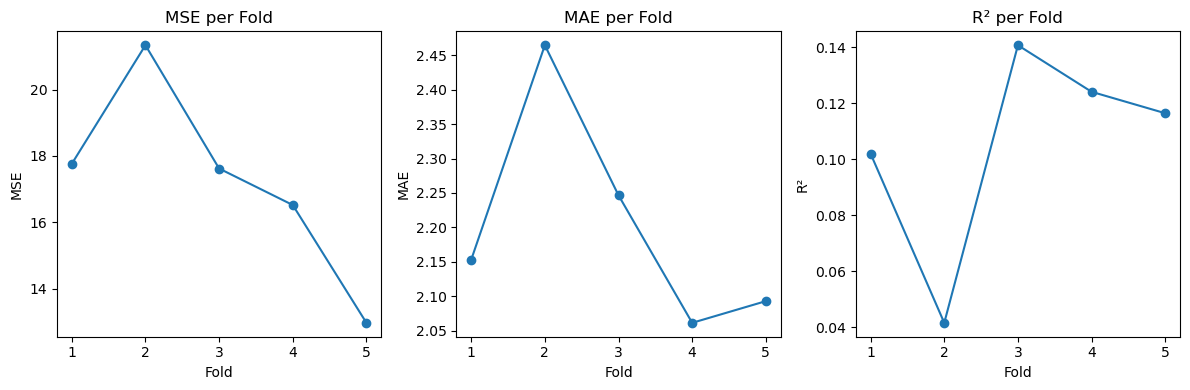

In [23]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_rf,
    X_selected_reg_cleaned,
    y_selected_reg_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_rf,
    data_name='reg_data_Kselect_cleaned',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=6>**SVR训练结果**</font>

<font size=5> **原始数据** </font>

<font size=5> **标准化数据** </font>

<font size=5> **K=10最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect 5 折=====

[Fold 1] MSE=290.6699, MAE=4.0755, R2=0.2828
[Fold 2] MSE=258.7043, MAE=4.1154, R2=0.2112
[Fold 3] MSE=274.7173, MAE=3.9747, R2=0.2122
[Fold 4] MSE=290.2829, MAE=3.7802, R2=0.2388
[Fold 5] MSE=379.6527, MAE=4.4638, R2=0.3597

=== 平均性能指标 reg_data_Kselect ===
MSE: 298.8054, MAE: 4.0819, R2: 0.2609

=== 最佳模型参数 ===
{'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
对应指标: {'mse': 379.6526848091028, 'mae': 4.463804706911464, 'r2': 0.35970159758766684}


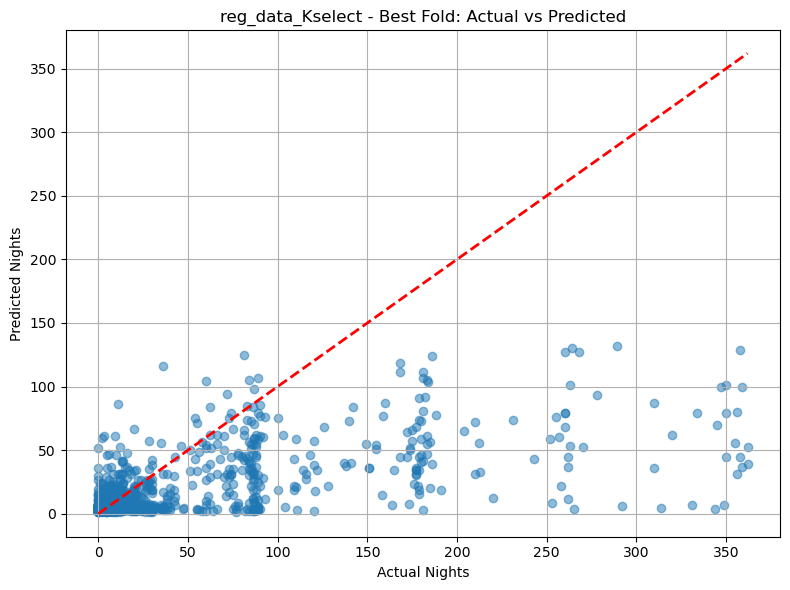

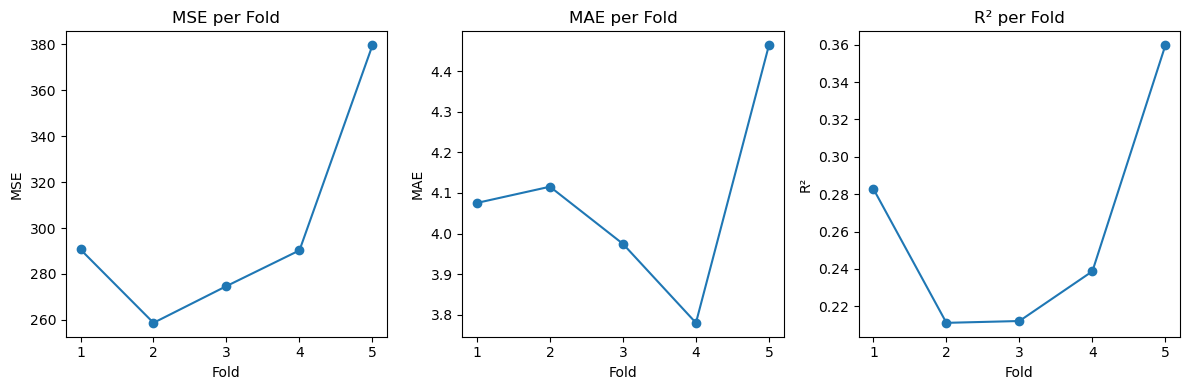

In [11]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_svr,
    X_selected_reg,
    y_selected_reg,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svr,
    data_name='reg_data_Kselect',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **K=50最优选择数据** </font>


===== 开始滚动评估：reg_data_Kselect_50 5 折=====

[Fold 1] MSE=355.2848, MAE=4.0209, R2=0.1234
[Fold 2] MSE=275.6529, MAE=3.9686, R2=0.1595
[Fold 3] MSE=300.5682, MAE=3.8578, R2=0.1380
[Fold 4] MSE=327.3428, MAE=3.7428, R2=0.1416
[Fold 5] MSE=468.6323, MAE=4.5820, R2=0.2096

=== 平均性能指标 reg_data_Kselect_50 ===
MSE: 345.4962, MAE: 4.0344, R2: 0.1544

=== 最佳模型参数 ===
{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
对应指标: {'mse': 468.6323127784708, 'mae': 4.581992060888131, 'r2': 0.20963413878732273}


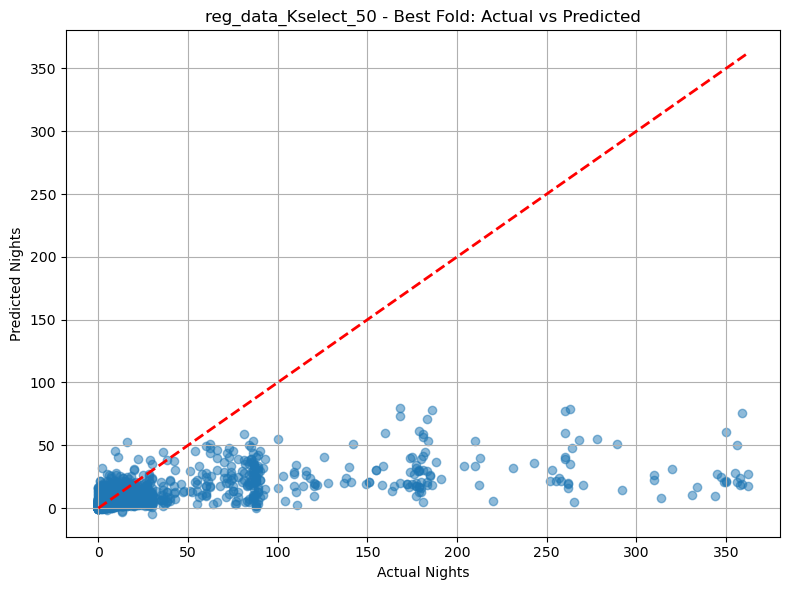

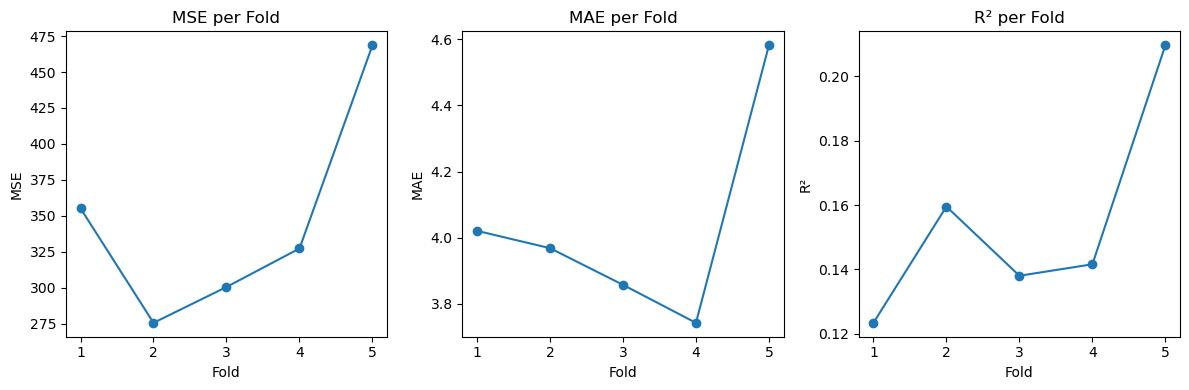

In [11]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_svr,
    X_selected_reg_50,
    y_selected_reg_50,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svr,
    data_name='reg_data_Kselect_50',
    n_jobs=-1
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5>**K=10最优选择清洗数据**</font>


===== 开始滚动评估：reg_data_Kselect_cleaned 5 折=====

[Fold 1] MSE=18.7741, MAE=2.1039, R2=0.0508
[Fold 2] MSE=22.6115, MAE=2.3760, R2=-0.0158
[Fold 3] MSE=19.0037, MAE=2.1750, R2=0.0734
[Fold 4] MSE=17.6689, MAE=2.0315, R2=0.0633
[Fold 5] MSE=13.7260, MAE=2.0511, R2=0.0652

=== 平均性能指标 reg_data_Kselect_cleaned ===
MSE: 18.3568, MAE: 2.1475, R2: 0.0474

=== 最佳模型参数 ===
{'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}
对应指标: {'mse': 19.003663719680475, 'mae': 2.175002561608548, 'r2': 0.07340627845587788}


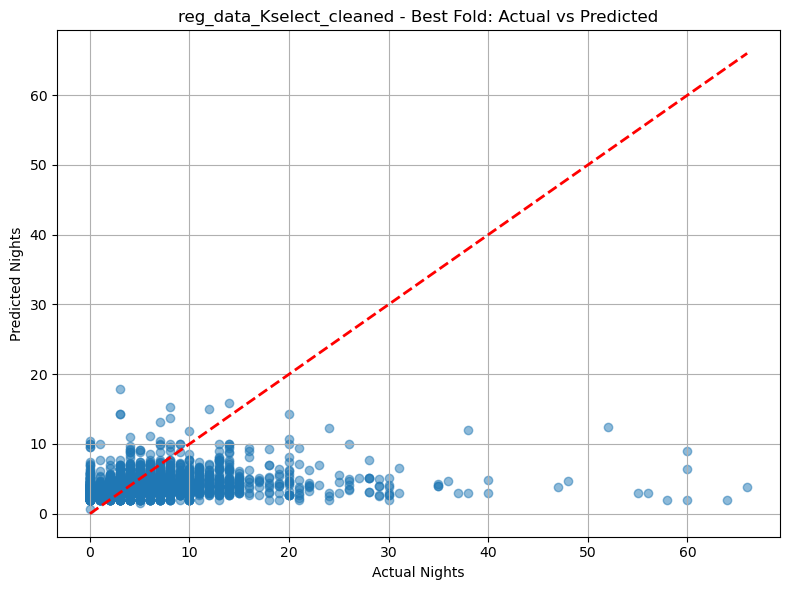

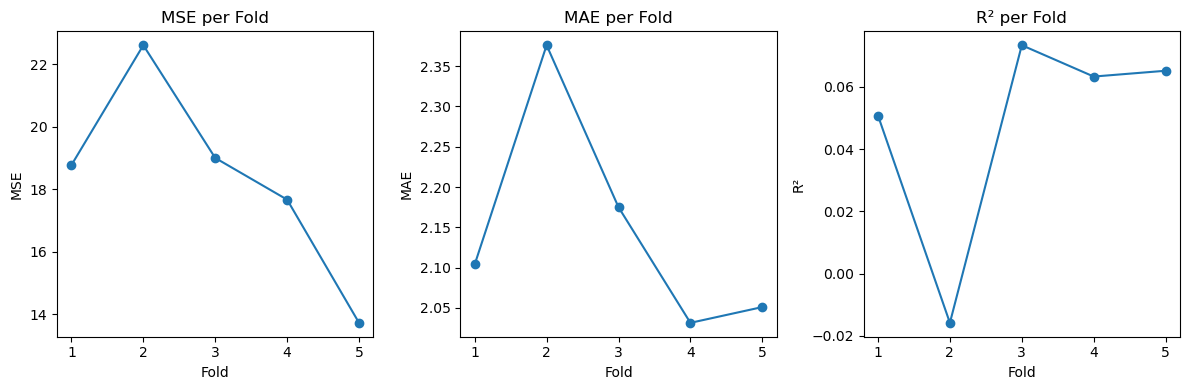

In [12]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_svr,
    X_selected_reg_cleaned,
    y_selected_reg_cleaned,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svr,
    data_name='reg_data_Kselect_cleaned',
    n_jobs=-1
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)

<font size=5> **pca数据** </font>

<font size=6>**以下别动！**</font>


===== 开始滚动评估：pca_data 5 折=====

[Fold 1] MSE=364.5163, MAE=4.2061, R2=0.1006
[Fold 2] MSE=280.4139, MAE=3.8682, R2=0.1450
[Fold 3] MSE=303.5393, MAE=3.8196, R2=0.1295
[Fold 4] MSE=317.7262, MAE=3.7525, R2=0.1668
[Fold 5] MSE=476.1165, MAE=4.6908, R2=0.1970

=== 平均性能指标 pca_data ===
MSE: 348.4624, MAE: 4.0674, R2: 0.1478

=== 最佳模型参数 ===
{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
对应指标: {'mse': 476.11646836529735, 'mae': 4.690826267090628, 'r2': 0.19701183145908696}


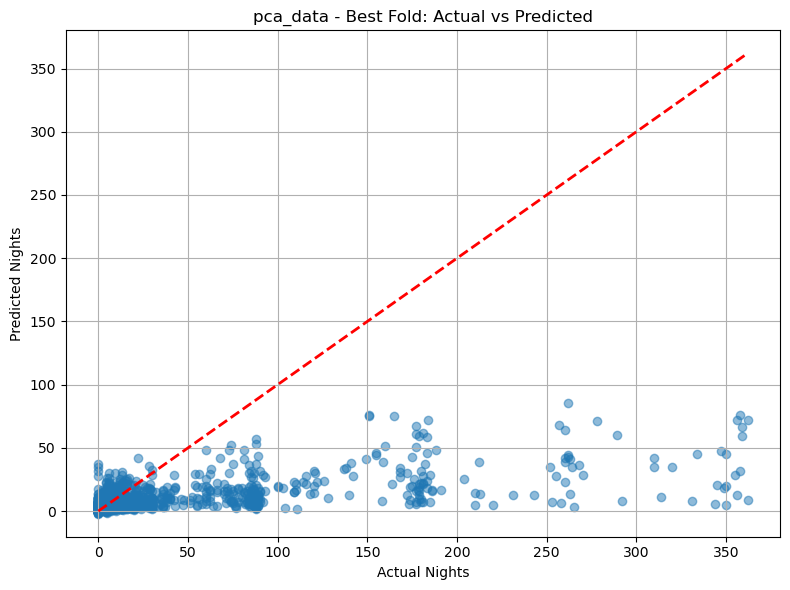

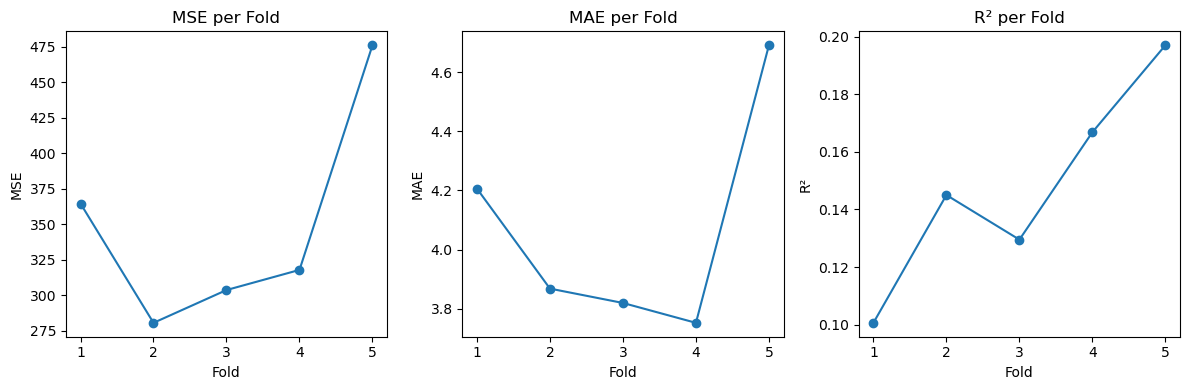

In [ ]:
# models = [
#     ('线性回归', model_lr, param_grid_lr),
#     ('Lasso', model_lasso, param_grid_lasso),
#     ('Ridge', model_ridge, param_grid_ridge),
#     ('随机森林', model_rf, param_grid_rf),
#     ('SVR', model_svr, param_grid_svr)
# ]

# data = X(y)_reg_ini / X(y)_reg_sca / X(y)_reg_pca / X(y)_selected_reg
best_model, metrics, avg_metrics, best_params = rolling_evaluate_model_regression(
    model_svr,
    X_reg_pca,
    y_reg_pca,
    n_splits=5,
    use_gridsearch=True,
    param_grid=param_grid_svr,
    data_name='pca_data',
    n_jobs=12
)

# 绘图查看每折的性能
plot_rolling_metrics(metrics)